# IMPORT MODULES 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from BorutaShap import BorutaShap
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams['figure.figsize']=[15,8]

In [5]:
df=pd.read_csv('C:/Users/0002FB744/Desktop/PGAA/CAPSTONE-1/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df['FastingBS']=df['FastingBS'].astype('O')
df['HeartDisease']=df['HeartDisease'].astype('O')

In [8]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS          object
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease       object
dtype: object

In [9]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [10]:
df.describe(include='O')

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
count,918,918,918,918,918,918,918
unique,2,4,2,3,2,3,2
top,M,ASY,0,Normal,N,Flat,1
freq,725,496,704,552,547,460,508


In [11]:
df.shape

(918, 12)

In [12]:
df_cat=df.select_dtypes(include='O')

In [13]:
df_cat.columns

Index(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina',
       'ST_Slope', 'HeartDisease'],
      dtype='object')

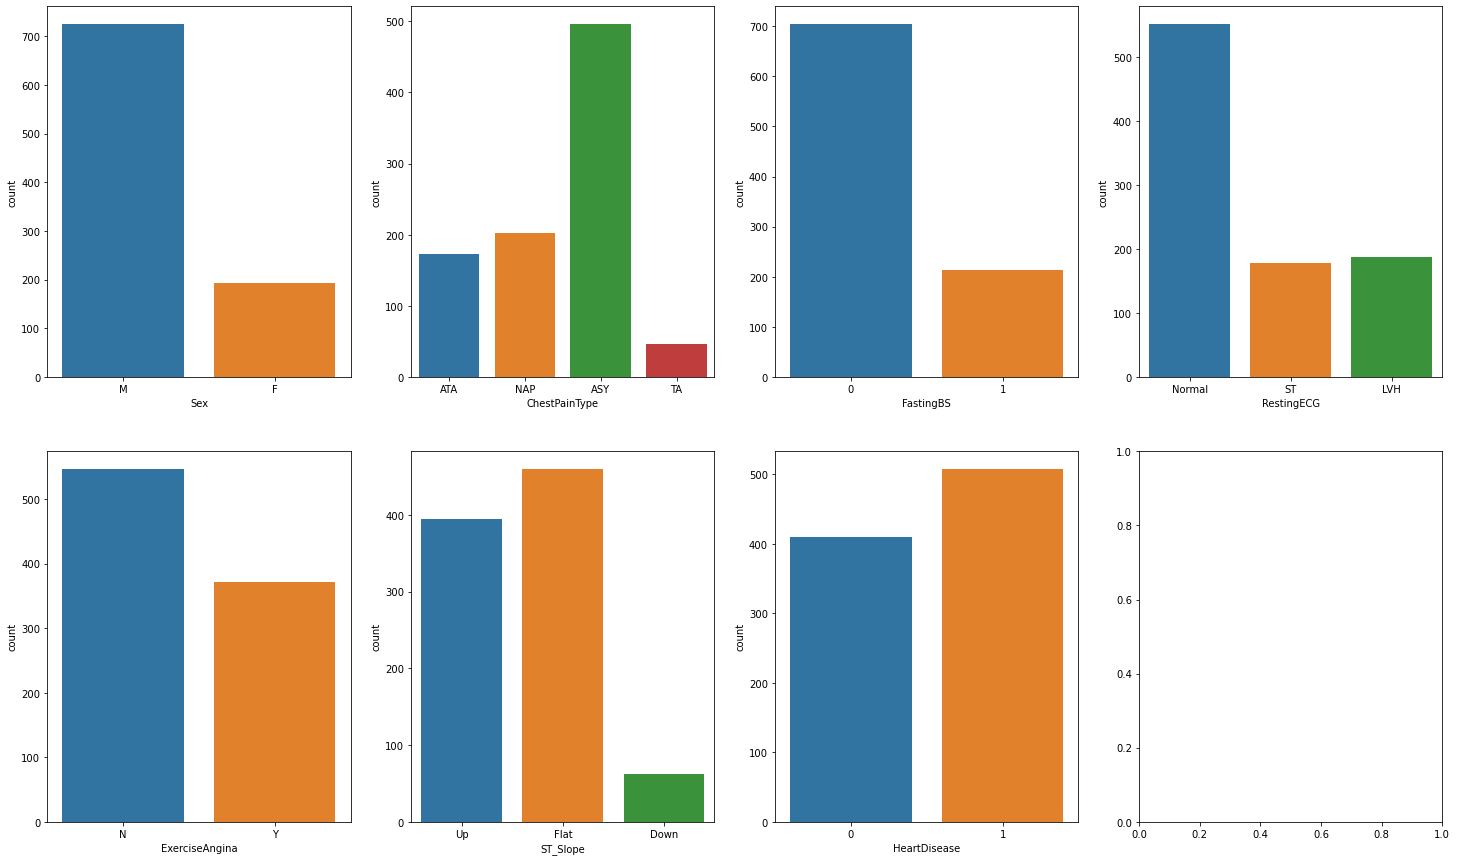

In [14]:
fig,ax=plt.subplots(nrows=2,ncols=4,figsize=(25,15))
for var,subplot in zip(df_cat.columns,ax.flatten()):
    sns.countplot(df[var],ax=subplot)

1) By looking at the graphs we can tell that most of the pateints are male.

2) Most of the pateints have experienced asymptotic type of chest pain. Around 200 pateints have experienced Atypical Angina and Non-Anginal kind of chest pain. very less around 50 pateints have experienced typical Angina kind of chest pain.

3) Most of the pateints have fasting blood sugar of less than 120 mg/dl.

4) Most of the pateints have normal resting ECG. Around 200 pateints have ECG of type ST and LVH.

5) more than 500 pateints didn't experience exercise-induced angina while around 350 pateints did experience exercise-induced angina.

6) The slope of the peak exercise ST segment is either up or flat for maximum pateints and down for very less number of patients.

7) around 500 pateints have experienced heart failure and 400 have not experienced. Looks like balanced class.

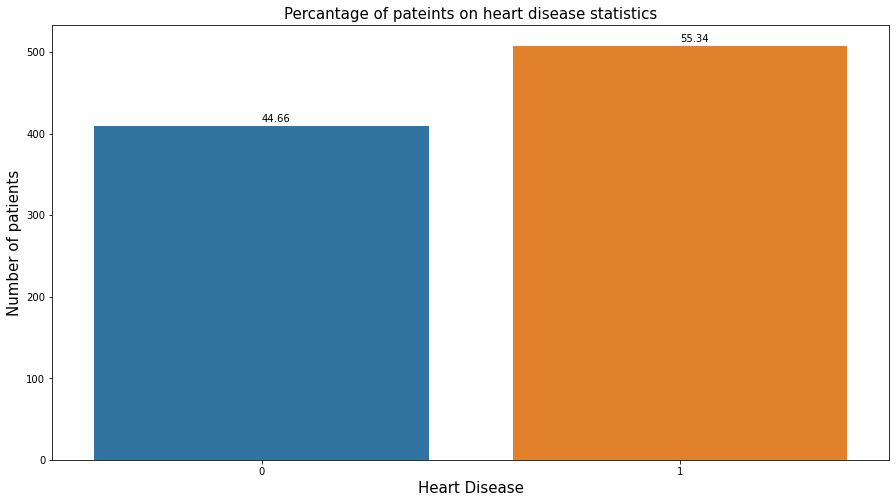

In [15]:
sns.countplot(df.HeartDisease)
plt.text(x=0,y=df['HeartDisease'].value_counts()[0]+5,s=str(round((df['HeartDisease'].value_counts(normalize=True)*100)[0],2)))
plt.text(x=1,y=df['HeartDisease'].value_counts()[1]+5,s=str(round((df['HeartDisease'].value_counts(normalize=True)*100)[1],2)))
plt.title('Percantage of pateints on heart disease statistics',fontsize=15)
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('Number of patients',fontsize=15)
plt.show()

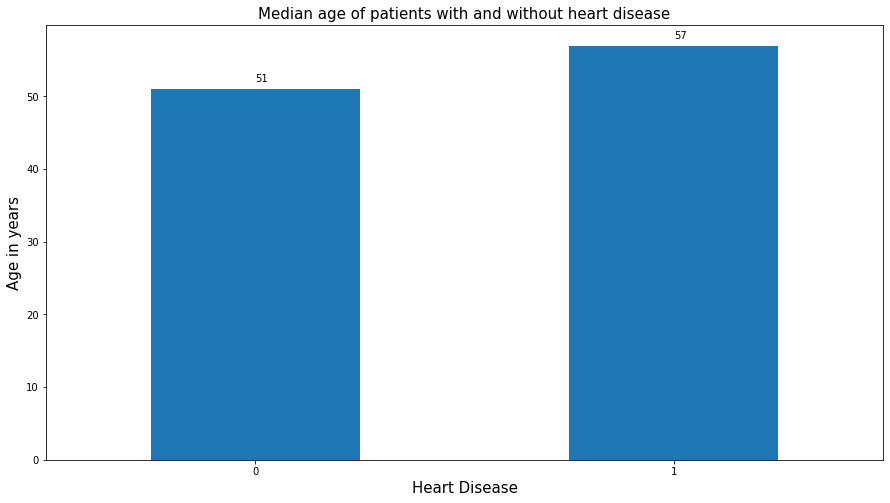

In [16]:
df.groupby('HeartDisease')['Age'].median().plot.bar(rot=0)
plt.text(x=0,y=df.groupby('HeartDisease')['Age'].median()[0]+1,s=str(df.groupby('HeartDisease')['Age'].median()[0]))
plt.text(x=1,y=df.groupby('HeartDisease')['Age'].median()[1]+1,s=str(df.groupby('HeartDisease')['Age'].median()[1]))
plt.title('Median age of patients with and without heart disease',fontsize=15)
plt.ylabel('Age in years',fontsize=15)
plt.xlabel('Heart Disease',fontsize=15)
plt.show()

In [17]:
(df.groupby('HeartDisease')['Sex'].value_counts(normalize=True)*100)[0]['M']


65.1219512195122

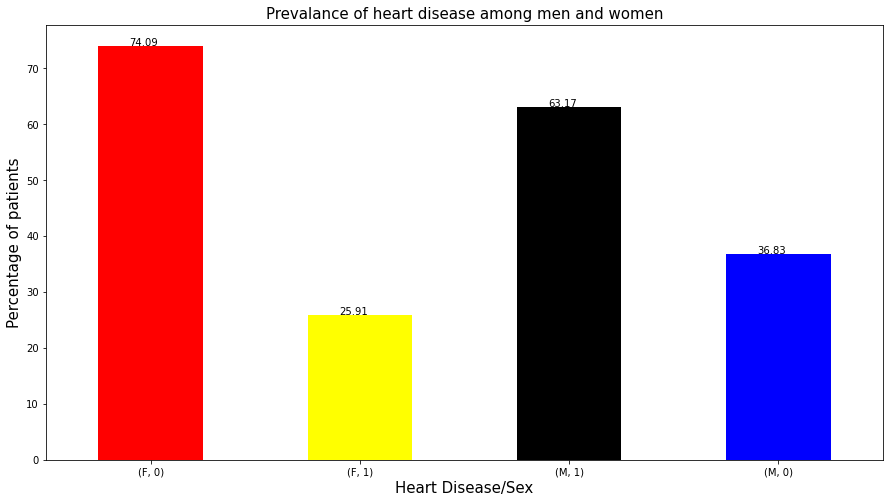

In [18]:
c = ['red', 'yellow', 'black', 'blue']
round(df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100,2).plot.bar(rot=0,color=c)
plt.text(x=-0.1,y=(df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100)['F'][0],s=str(round((df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100)['F'][0],2)))
plt.text(x=0.9,y=(df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100)['F'][1],s=str(round((df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100)['F'][1],2)))
plt.text(x=1.9,y=(df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100)['M'][1],s=str(round((df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100)['M'][1],2)))
plt.text(x=2.9,y=(df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100)['M'][0],s=str(round((df.groupby('Sex')['HeartDisease'].value_counts(normalize=True)*100)['M'][0],2)))
plt.title('Prevalance of heart disease among men and women',fontsize=15)
plt.xlabel('Heart Disease/Sex',fontsize=15)
plt.ylabel('Percentage of patients',fontsize=15)
plt.show()

Overall, the classes in our target variable, HeartDisease, are relatively balanced. Out of the total 918 patients in the data, 55.34% patients have been diagnosed with heart failure while 44.66% have not. The median age of patients with heart disease is 57, while those without heart disease are slightly younger with a median age of 51. Among men, approximately 63% have heart disease, while in women, about 1 in every 4 have been diagnosed with heart disease.

In [19]:
type(df[df.HeartDisease == 0]['Age'][0])

numpy.int64

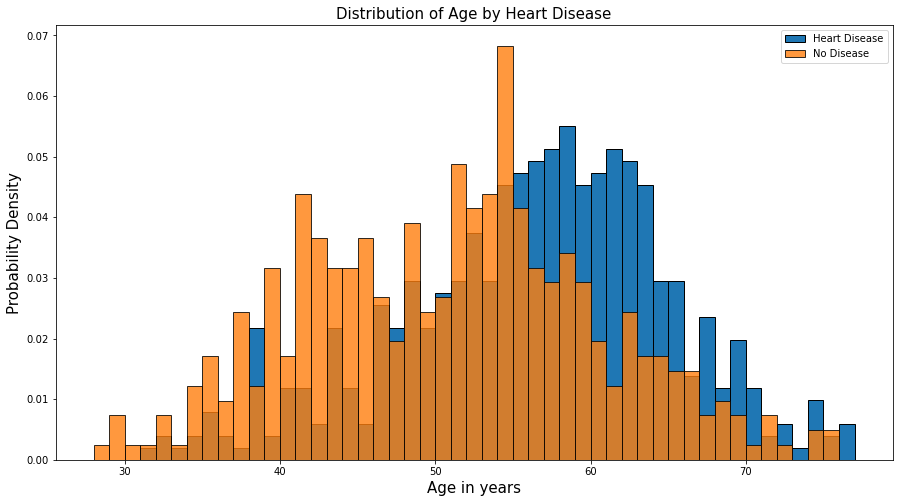

In [20]:
plt.hist(df[df.HeartDisease == 1]['Age'],density=True,stacked=True,ec='black',rwidth=1,histtype='barstacked',label='Heart Disease',bins=range(min(df[df.HeartDisease == 1]['Age']),max(df[df.HeartDisease == 1]['Age'])+1))
plt.hist(df[df.HeartDisease == 0]['Age'],density=True,stacked=True,alpha=0.8,ec='black',rwidth=1,histtype='barstacked',label='No Disease',bins=range(min(df[df.HeartDisease == 0]['Age']),max(df[df.HeartDisease == 0]['Age'])+1))
plt.title('Distribution of Age by Heart Disease',fontsize=15)
plt.xlabel('Age in years',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
plt.legend()
plt.show()

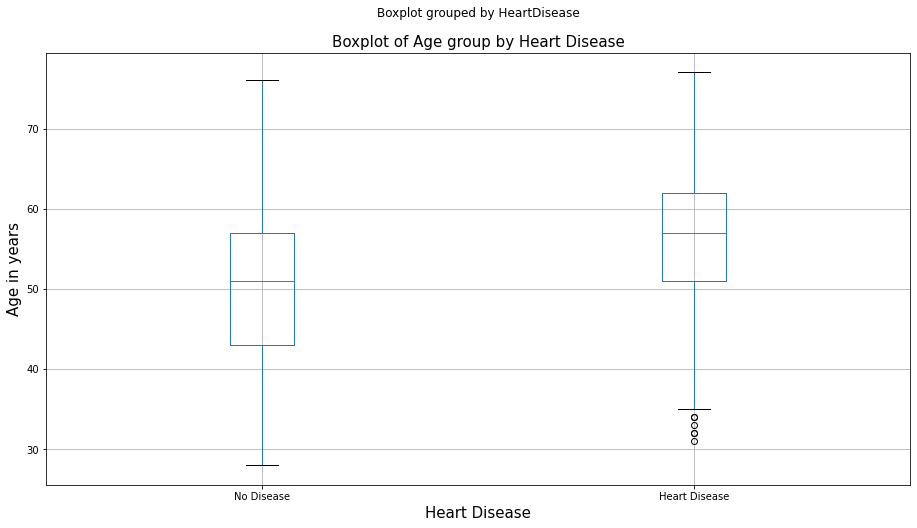

In [21]:
df.boxplot(column=['Age'],by='HeartDisease')
plt.title('Boxplot of Age group by Heart Disease',fontsize=15)
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('Age in years',fontsize=15)
plt.xticks(ticks=[1,2],labels=['No Disease','Heart Disease'])
plt.show()

Age: In patients with heart disease, there is a smaller spread in the boxplot with the majority of patients between the ages of 51 to 62. There are also a few younger outliers in this group that are below the lower whisker. In patients without heart disease, there is a slightly wider variation in age that is more evenly distributed, with no outliers. The majority of patients in this group are within a younger age range of 43 to 57.

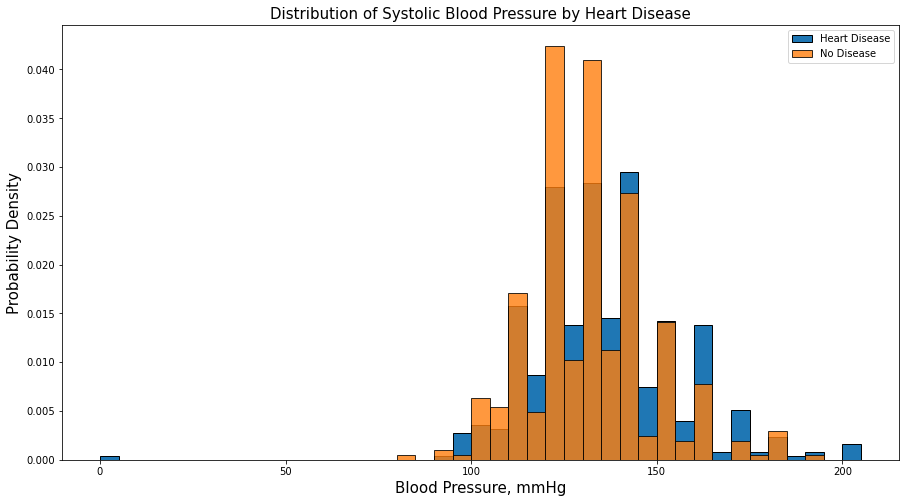

In [22]:
plt.hist(df[df.HeartDisease == 1]['RestingBP'],density=True,stacked=True,ec='black',histtype='barstacked',label='Heart Disease',bins=range(0,210,5))
plt.hist(df[df.HeartDisease == 0]['RestingBP'],density=True,alpha=0.8,stacked=True,ec='black',histtype='barstacked',label='No Disease',bins=range(0,210,5))
plt.title('Distribution of Systolic Blood Pressure by Heart Disease',fontsize=15)
plt.xlabel('Blood Pressure, mmHg',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
plt.legend()
plt.show()

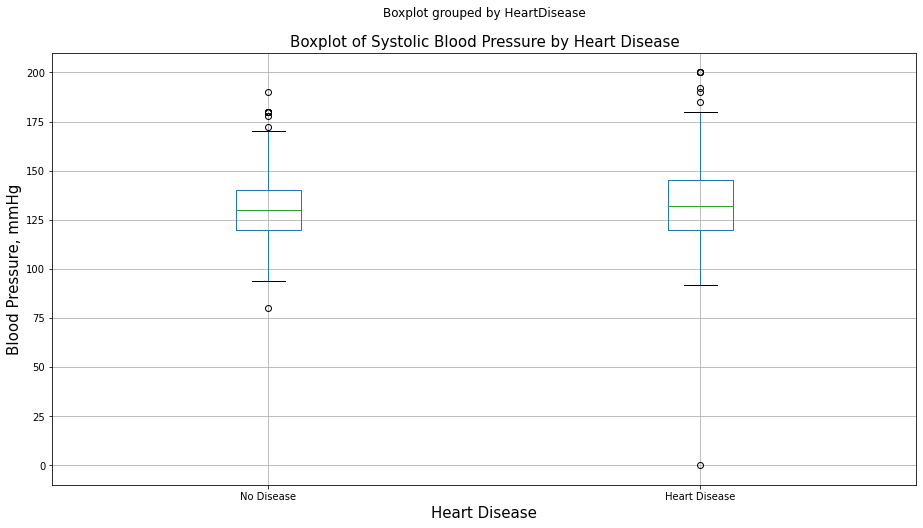

In [23]:
df.boxplot(column=['RestingBP'],by='HeartDisease')
plt.title('Boxplot of Systolic Blood Pressure by Heart Disease',fontsize=15)
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('Blood Pressure, mmHg',fontsize=15)
plt.xticks(ticks=[1,2],labels=['No Disease','Heart Disease'])
plt.show()

Systolic Blood Pressure: The boxplots are proportional between the groups. Both have upper and lower outliers, with most patients' blood pressure in the range of 120 to 145 mmHg. The median blood pressure is about 130 mmHg in both groups.

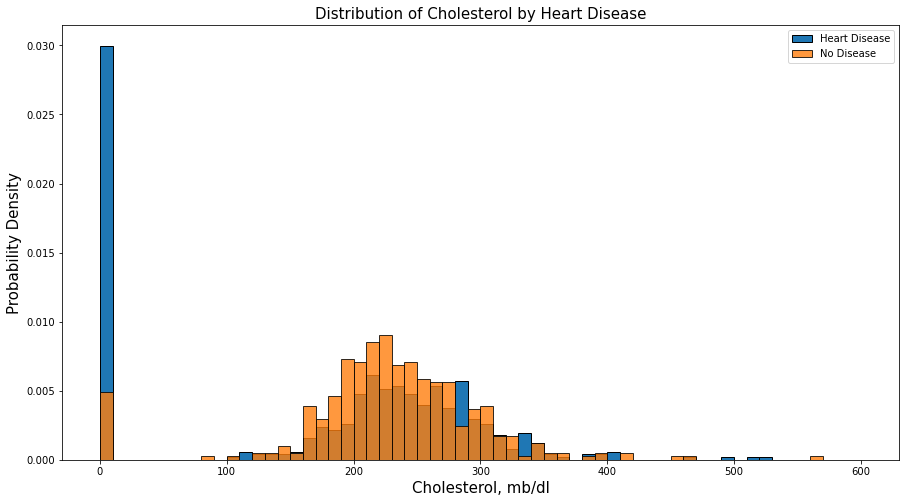

In [24]:
plt.hist(df[df.HeartDisease == 1]['Cholesterol'],stacked=True,histtype='barstacked',density=True,ec='black',label='Heart Disease',bins=range(0,610,10))
plt.hist(df[df.HeartDisease == 0]['Cholesterol'],stacked=True,alpha=0.8,histtype='barstacked',density=True,ec='black',label='No Disease',bins=range(0,610,10))
plt.title('Distribution of Cholesterol by Heart Disease',fontsize=15)
plt.xlabel('Cholesterol, mb/dl',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
plt.legend()
plt.show()

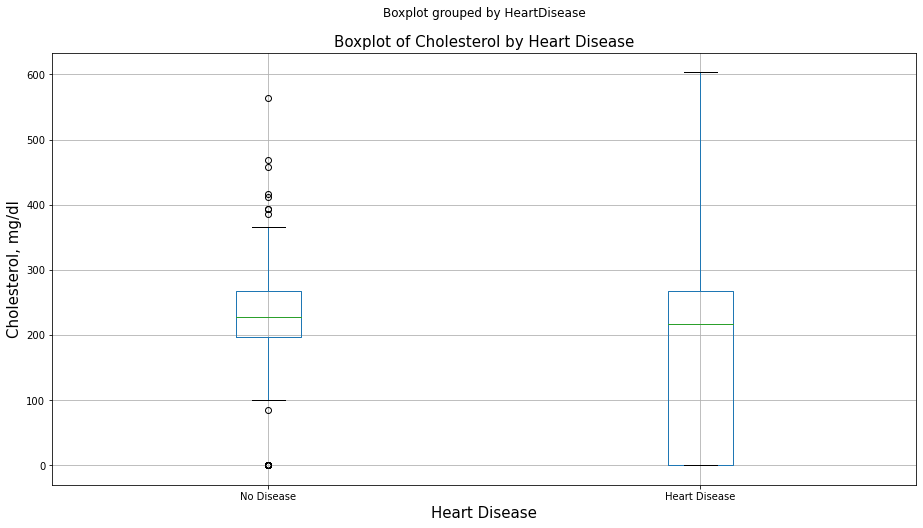

In [25]:
df.boxplot(column=['Cholesterol'],by='HeartDisease')
plt.title('Boxplot of Cholesterol by Heart Disease',fontsize=15)
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('Cholesterol, mg/dl',fontsize=15)
plt.xticks(ticks=[1,2],labels=['No Disease','Heart Disease'])
plt.show()

Cholesterol: The distribution of cholesterol appears to be skewed to the right, especially in patients with heart disease where there are a large number of observations missing cholesterol levels that were entered as 0. These values will be addressed in the data cleaning section.

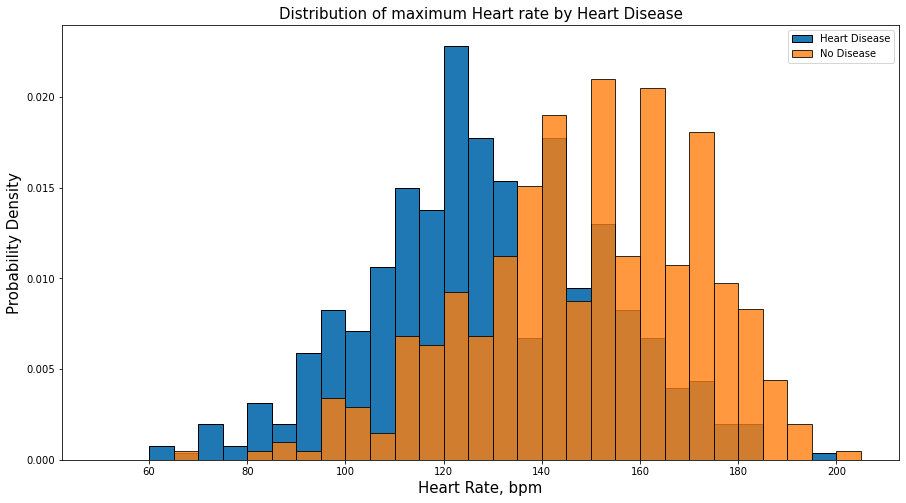

In [26]:
plt.hist(df[df.HeartDisease == 1]['MaxHR'],density=True,stacked=True,ec='black',rwidth=1,histtype='barstacked',label='Heart Disease',bins=range(50,210,5))
plt.hist(df[df.HeartDisease == 0]['MaxHR'],density=True,stacked=True,alpha=0.8,ec='black',rwidth=1,histtype='barstacked',label='No Disease',bins=range(50,210,5))
plt.title('Distribution of maximum Heart rate by Heart Disease',fontsize=15)
plt.xlabel('Heart Rate, bpm',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
plt.legend()
plt.show()

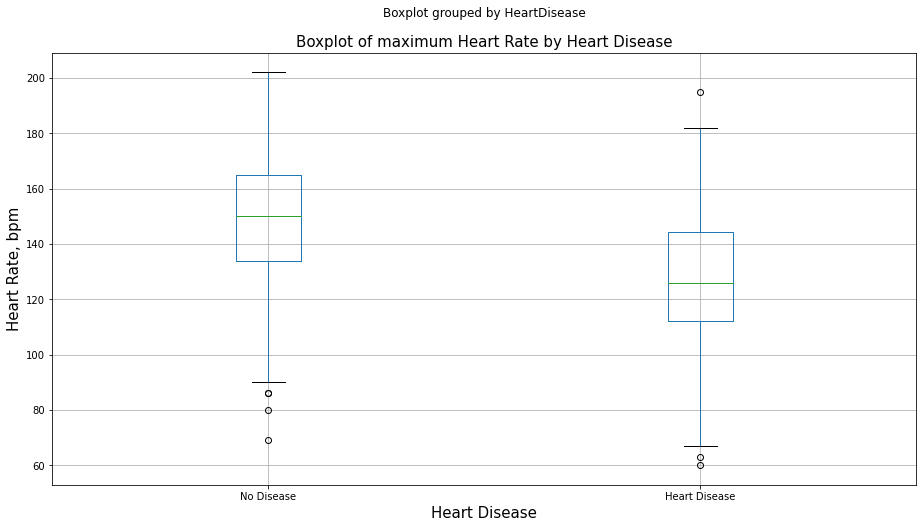

In [27]:
df.boxplot(column=['MaxHR'],by='HeartDisease')
plt.title('Boxplot of maximum Heart Rate by Heart Disease',fontsize=15)
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('Heart Rate, bpm',fontsize=15)
plt.xticks(ticks=[1,2],labels=['No Disease','Heart Disease'])
plt.show()

Heart Rate: Patients without heart disease are able to reach higher maximum heart rates than patients with heart disease, with a median heart rate of 150 beats per minute versus a median of 126 beats per minute in cardiovascular patients.

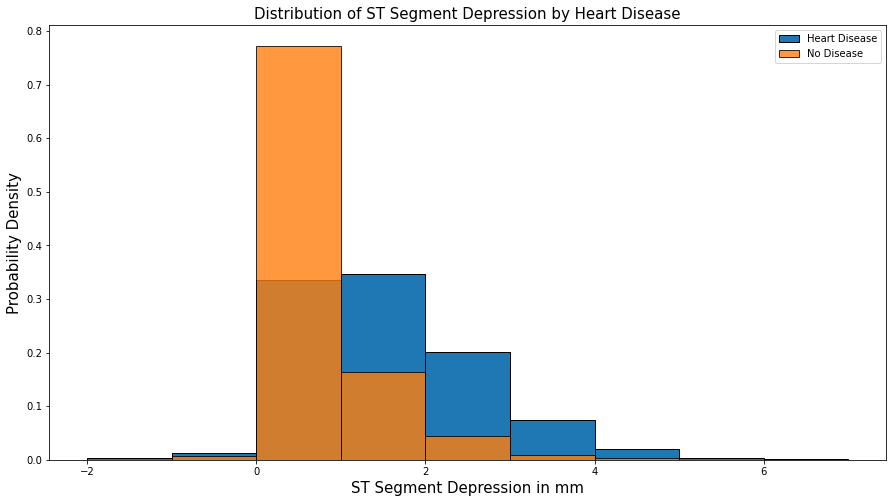

In [28]:
width1=(max(df[df.HeartDisease == 1]['Oldpeak'])-min(df[df.HeartDisease == 1]['Oldpeak']))/len(df[df.HeartDisease == 1]['Oldpeak'])
width0=(max(df[df.HeartDisease == 0]['Oldpeak'])-min(df[df.HeartDisease == 0]['Oldpeak']))/len(df[df.HeartDisease == 0]['Oldpeak'])
plt.hist(df[df.HeartDisease == 1]['Oldpeak'],density=True,stacked=True,ec='black',rwidth=1,histtype='barstacked',label='Heart Disease',bins=range(int(min(df[df.HeartDisease == 1]['Oldpeak'])),int(max(df[df.HeartDisease == 1]['Oldpeak']))+int(width1)+2))
plt.hist(df[df.HeartDisease == 0]['Oldpeak'],density=True,stacked=True,alpha=0.8,ec='black',rwidth=1,histtype='barstacked',label='No Disease',bins=range(int(min(df[df.HeartDisease == 0]['Oldpeak'])),int(max(df[df.HeartDisease == 0]['Oldpeak']))+int(width0)+2))
plt.title('Distribution of ST Segment Depression by Heart Disease',fontsize=15)
plt.xlabel('ST Segment Depression in mm',fontsize=15)
plt.ylabel('Probability Density',fontsize=15)
plt.legend()
plt.show()

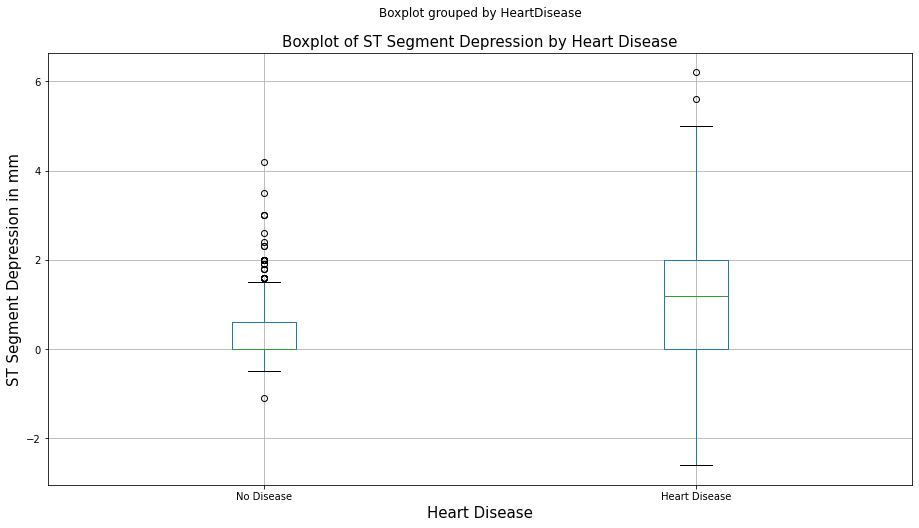

In [29]:
df.boxplot(column=['Oldpeak'],by='HeartDisease')
plt.title('Boxplot of ST Segment Depression by Heart Disease',fontsize=15)
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('ST Segment Depression in mm',fontsize=15)
plt.xticks(ticks=[1,2],labels=['No Disease','Heart Disease'])
plt.show()

ST Segment Depression (OldPeak): There is a notable difference in the distribution of ST segment depression between the groups. In patients with heart disease, there is more variability in ST depression with several larger outliers. Most patients in this group have ST depressions between 0 to 2 mm with a median of 1.2 mm. In patients without heart disease, the range is smaller comparatively, between 0 to 0.6 mm, with a median ST depression of 0 mm, although the distribution of this group exhibits more skewness overall.

In [30]:
df_num=df.select_dtypes(include=np.number)
print(df_num.columns.values)

['Age' 'RestingBP' 'Cholesterol' 'MaxHR' 'Oldpeak']


In [31]:
df1=df
df1.HeartDisease=df1.HeartDisease.astype(np.number)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    float64
dtypes: float64(2), int64(4), object(6)
memory usage: 86.2+ KB


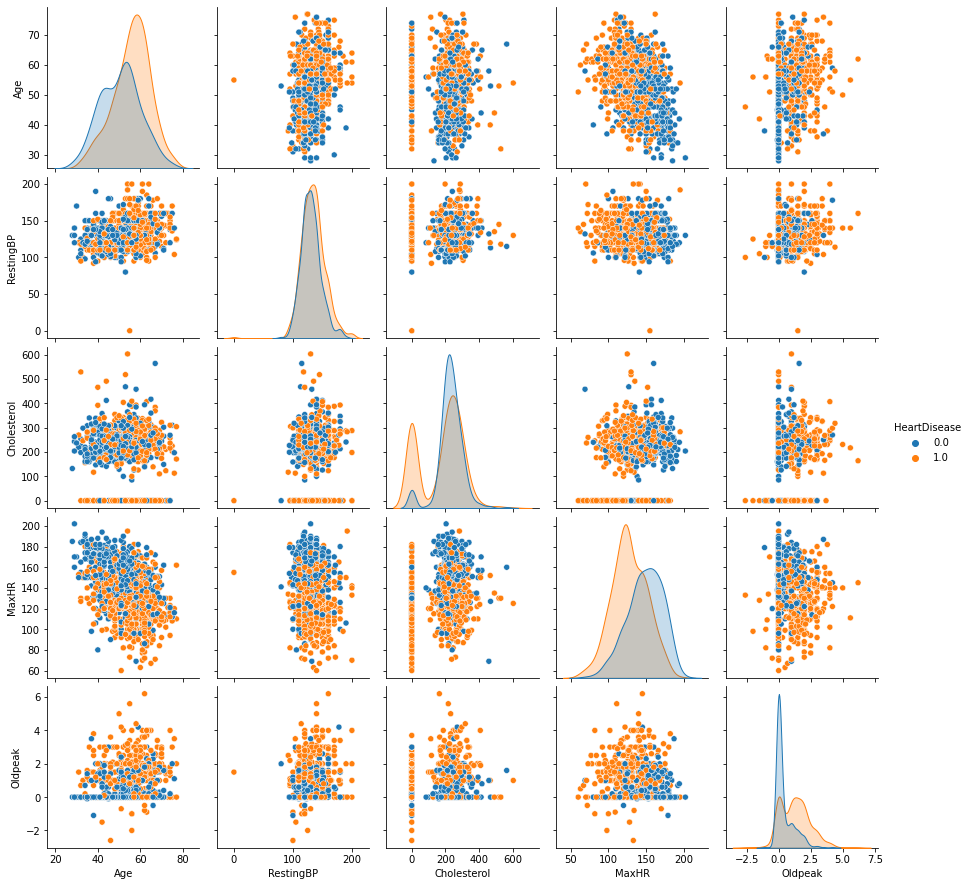

In [32]:
sns.pairplot(data=df,x_vars=df_num.columns.values,y_vars=df_num.columns.values,diag_kind='kde',hue='HeartDisease',vars=df_num.columns.values)
plt.show()

In [33]:
corr=df1.corr()
corr

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,0.235792,0.050148,-0.232741
MaxHR,-0.382045,-0.112135,0.235792,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,-0.400421,0.403951,1.000000


<AxesSubplot:>

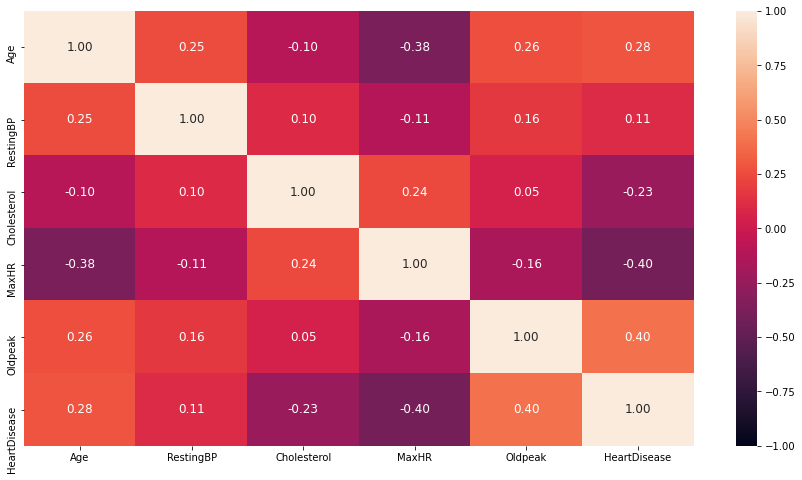

In [34]:
sns.heatmap(corr,vmax=1,vmin=-1,annot=True,fmt='.2f',annot_kws={'size':12})

Based on the correlations and scatterplots, HeartDisease has the moderate positive association to OldPeak (correlation = 0.4) and the moderate negative association to MaxHR (correlation = -0.4). There is also a moderately strong relationship between Age and MaxHR of -0.38. As age increases, heart rate tends to decrease.

<AxesSubplot:>

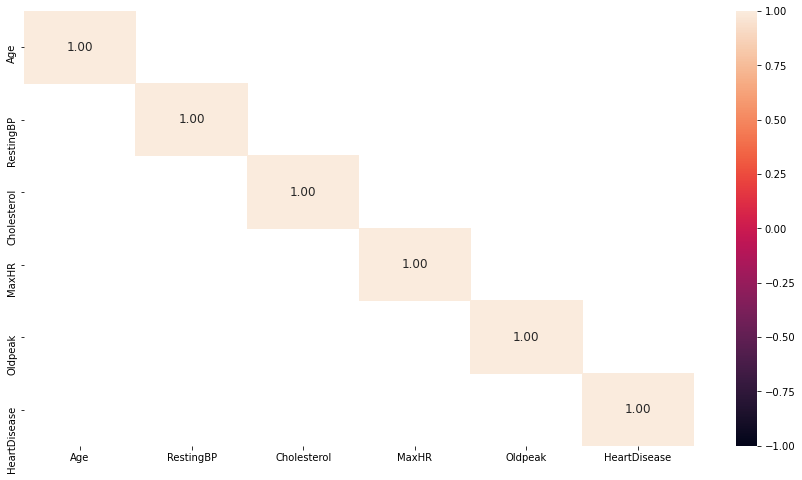

In [35]:
sns.heatmap(corr[(corr>=0.8)|(corr<=-0.8)],vmax=1,vmin=-1,annot=True,fmt='.2f',annot_kws={'size':12})

As we can see there is no strong correlation between the columns.

In [36]:
print(list(df_cat.columns))

['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']


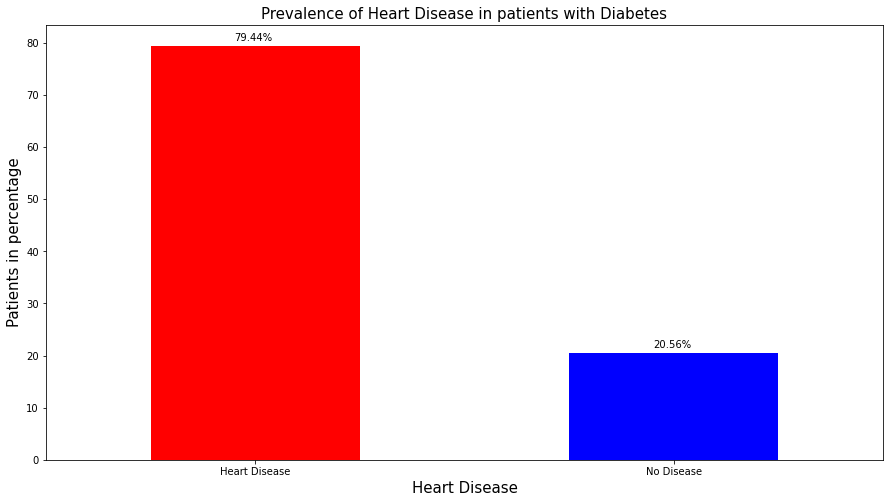

In [37]:
val=round(df[df['FastingBS']==1]['HeartDisease'].value_counts(normalize=True)*100,2)
round(df[df['FastingBS']==1]['HeartDisease'].value_counts(normalize=True)*100,2).plot(kind='bar',rot=0,color=['red','blue'])
plt.text(x=-0.05,y=val[1]+1,s=str(val[1])+'%')
plt.text(x=0.95,y=val[0]+1,s=str(val[0])+'%')
plt.title('Prevalence of Heart Disease in patients with Diabetes',fontsize=15)
plt.xticks(ticks=[0,1],labels=['Heart Disease','No Disease'])
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('Patients in percentage',fontsize=15)
plt.show()

In patients with diabetes, nearly 80% have heart disease.

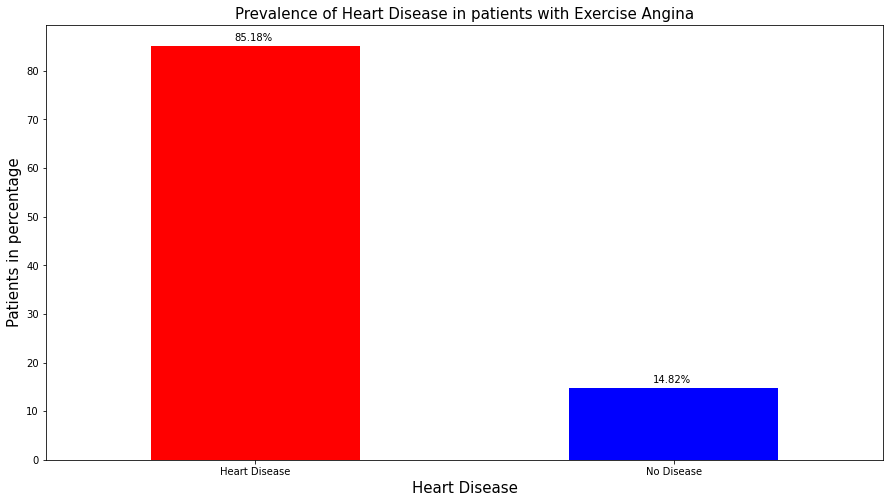

In [38]:
val=round(df[df['ExerciseAngina']=='Y']['HeartDisease'].value_counts(normalize=True)*100,2)
round(df[df['ExerciseAngina']=='Y']['HeartDisease'].value_counts(normalize=True)*100,2).plot(kind='bar',rot=0,color=['red','blue'])
plt.text(x=-0.05,y=val[1]+1,s=str(val[1])+'%')
plt.text(x=0.95,y=val[0]+1,s=str(val[0])+'%')
plt.title('Prevalence of Heart Disease in patients with Exercise Angina',fontsize=15)
plt.xticks(ticks=[0,1],labels=['Heart Disease','No Disease'])
plt.xlabel('Heart Disease',fontsize=15)
plt.ylabel('Patients in percentage',fontsize=15)
plt.show()

The prevalence of heart disease is even higher in patients with exercise angina at over 85%.

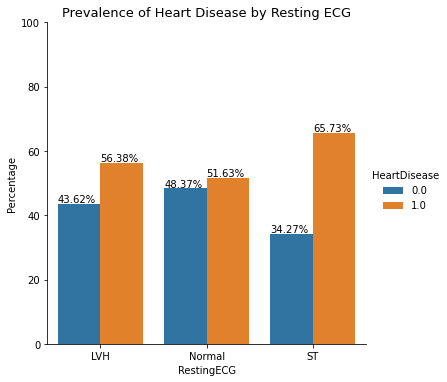

In [39]:
p=round(df.groupby('RestingECG')['HeartDisease'].value_counts(normalize=True)*100,2)
p=p.rename('Percentage').reset_index()
g=sns.catplot(x='RestingECG',y='Percentage',hue='HeartDisease',data=p,kind='bar')
g.ax.set_ylim(0,100)
for i in g.ax.patches:
    txt=str(i.get_height())+'%'
    x_txt=i.get_x()
    y_txt=i.get_height()+0.5
    g.ax.text(x_txt,y_txt,txt)
plt.title('Prevalence of Heart Disease by Resting ECG',fontsize=13)
plt.show()

Based on the resting ECG test results, over 65% of patients who were diagnosed with heart disease had ST-T wave abnormalities in their ECG, the highest proportion among the groups.

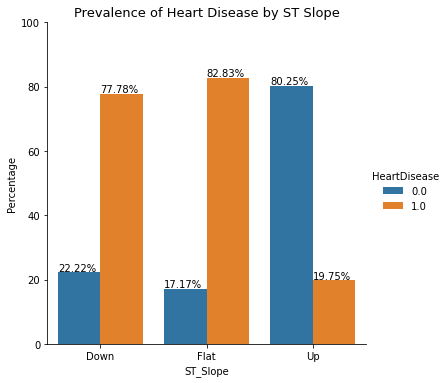

In [40]:
p=round(df.groupby('ST_Slope')['HeartDisease'].value_counts(normalize=True)*100,2)
p=p.rename('Percentage').reset_index()
g=sns.catplot(x='ST_Slope',y='Percentage',hue='HeartDisease',data=p,kind='bar')
g.ax.set_ylim(0,100)
for i in g.ax.patches:
    txt=str(i.get_height())+'%'
    x_txt=i.get_x()
    y_txt=i.get_height()+0.5
    g.ax.text(x_txt,y_txt,txt)
plt.title('Prevalence of Heart Disease by ST Slope',fontsize=13)
plt.show()

Patients with a Flat or Downward ST Slope while exercising have the highest prevalence of cardiovascular disease at 82.8% and 77.8%, respectively.

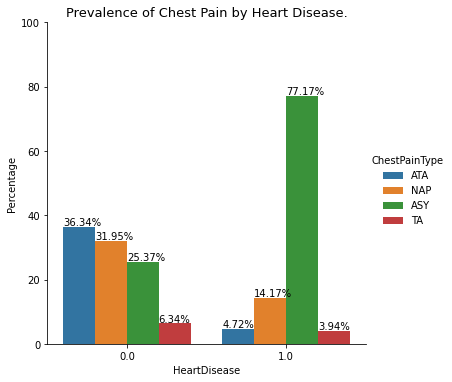

In [41]:
p=round(df.groupby('HeartDisease')['ChestPainType'].value_counts(normalize=True)*100,2)
p=p.rename('Percentage').reset_index()
g=sns.catplot(x='HeartDisease',y='Percentage',hue='ChestPainType',data=p,kind='bar')
g.ax.set_ylim(0,100)
for i in g.ax.patches:
    txt=str(i.get_height())+'%'
    x_txt=i.get_x()
    y_txt=i.get_height()+0.5
    g.ax.text(x_txt,y_txt,txt)
plt.title('Prevalence of Chest Pain by Heart Disease.',fontsize=13)
plt.show()

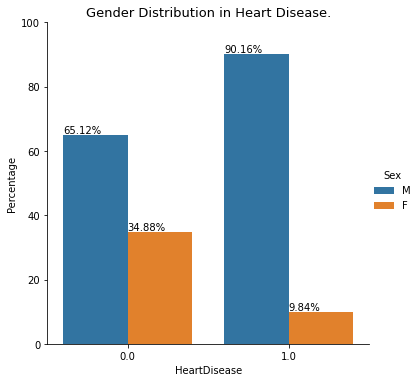

In [42]:
p=round(df.groupby('HeartDisease')['Sex'].value_counts(normalize=True)*100,2)
p=p.rename('Percentage').reset_index()
g=sns.catplot(x='HeartDisease',y='Percentage',hue='Sex',data=p,kind='bar')
g.ax.set_ylim(0,100)
for i in g.ax.patches:
    txt=str(i.get_height())+'%'
    x_txt=i.get_x()
    y_txt=i.get_height()+0.5
    g.ax.text(x_txt,y_txt,txt)
plt.title('Gender Distribution in Heart Disease.',fontsize=13)
plt.show()

Among patients with heart disease, the absence of chest pain (asymptomatic) is the most common at over 77%. In addition, heart disease is more prevalent in men than women, occurring at a rate of nearly 9 to 1 in patients with a cardiovascular diagnosis.

In [43]:
df_cat=df.select_dtypes(include='O')

In [44]:
chi_statistic=[]
p_val=[]
for i in list(df_cat.columns):
    observed=pd.crosstab(index=df["HeartDisease"], columns=df[i])
    stat, p, dof, expected=chi2_contingency(observed)
    chi_statistic.append(stat)
    p_val.append(p)
chi_df = pd.DataFrame(index=list(df_cat.columns))
chi_df["Chi Statistic"] = chi_statistic
chi_df["P-value"] = p_val
chi_df=chi_df.sort_values("P-value", ascending=True)
chi_df
display(chi_df.style.format({"Chi Statistic": "{:.2f}", "P-value": "{:.5f}"}))

,Chi Statistic,P-value
ST_Slope,355.92,0.00000
ChestPainType,268.07,0.00000
ExerciseAngina,222.26,0.00000
Sex,84.15,0.00000
FastingBS,64.32,0.00000
RestingECG,10.93,0.00423


Based on the chi-squared results, all discrete variables have a significant association to Heart Disease with a p-value < 0.05, and will therefore be included as predictors in the models.

Replace the missing values in Cholesterol that were entered as 0's. To do this, I will group the data by HeartDisease and fill the missing values with the mean for each group.

In [45]:
df.Cholesterol=df.Cholesterol.replace(0,np.nan)
df['Cholesterol']=df['Cholesterol'].fillna(df.groupby('HeartDisease')['Cholesterol'].transform('mean'))

In [46]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values.

<AxesSubplot:>

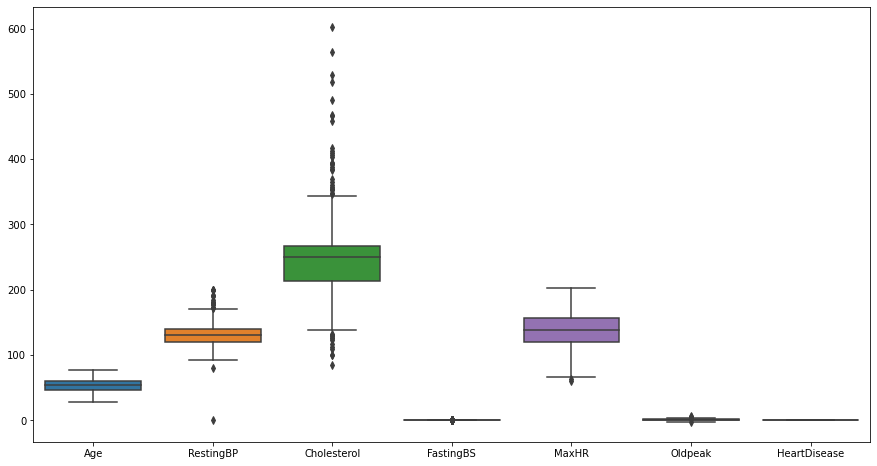

In [47]:
sns.boxplot(data=df)

As we can see here RestingBP, Cholesterol, MaxHR has some outliers and. We are unable to figure out whether FastingBS and Oldpeak has outliers or not. we will draw the boxplot separately.

<AxesSubplot:>

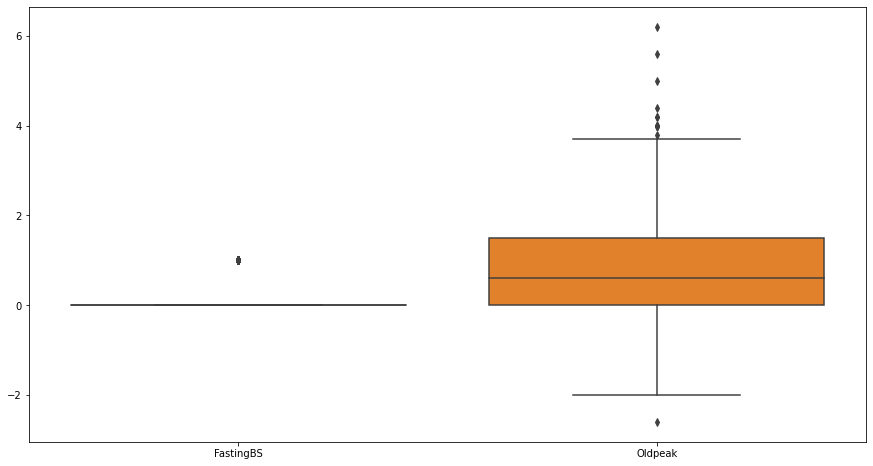

In [48]:
cols=['FastingBS','Oldpeak']
o_df=df[cols]
sns.boxplot(data=o_df)

Looks like FastingBS and Oldpeak has some outliers after all. We will remove the outliers using IQR method.

In [49]:
df_test=df.copy()

In [50]:
df.shape,df_test.shape

((918, 12), (918, 12))

In [51]:
df_test['HeartDisease']=df_test['HeartDisease'].astype('O')

In [53]:
#Removing outliers by IQR method
Q1=df_test.quantile(0.25)
Q3=df_test.quantile(0.75)
IQR=Q3-Q1
print(IQR)

Age            13.0
RestingBP      20.0
Cholesterol    53.0
MaxHR          36.0
Oldpeak         1.5
dtype: float64


In [54]:
df_test=df_test[~((df_test>(Q3+IQR*1.5)) | (df_test<(Q1-IQR*1.5))).any(axis=1)]
df_test=df_test.reset_index(drop=True)

In [55]:
df_test.shape

(836, 12)

<AxesSubplot:>

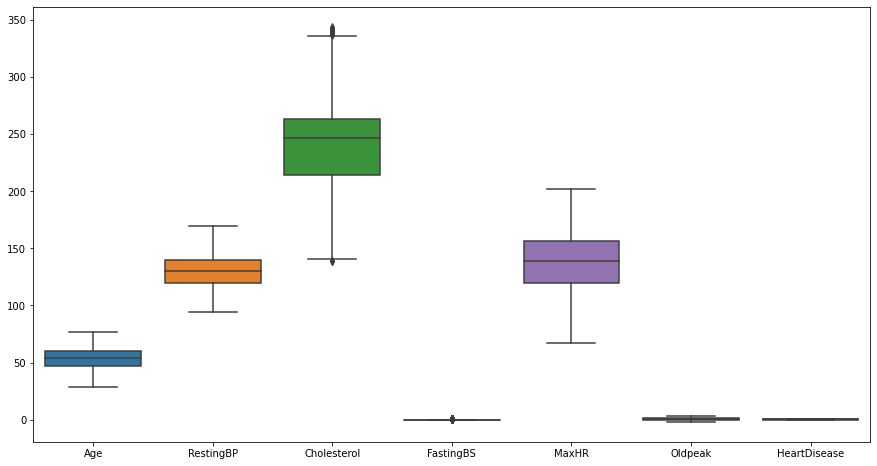

In [57]:
sns.boxplot(data=df_test)

In [56]:
df_test['HeartDisease']=df_test['HeartDisease'].astype(np.number)

In [91]:
Y=df['HeartDisease']
X=df.drop('HeartDisease',axis=1)
Y_t=df_test['HeartDisease']
X_t=df_test.drop('HeartDisease',axis=1)

In [92]:
Y.shape,X.shape,X_t.shape,Y_t.shape

((918,), (918, 11), (836, 11), (836,))

In [93]:
cat=list(df_cat.columns)
print(cat)

['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [94]:
X=pd.get_dummies(X,columns=cat,drop_first=True)
X_t=pd.get_dummies(X_t,columns=cat,drop_first=True)

In [95]:
X.shape,X_t.shape

((918, 15), (836, 15))

In [96]:
x_train,X2,y_train,Y2=train_test_split(X,Y,train_size=0.7,stratify=df.HeartDisease,random_state=10)
print('with df dataframe')
print(x_train.shape),print(y_train.shape),print(X2.shape),print(Y2.shape)
xt_train,X2_t,yt_train,Y2_t=train_test_split(X_t,Y_t,train_size=0.7,stratify=df_test.HeartDisease,random_state=10)
print('with df_test dataframe')
print(xt_train.shape),print(yt_train.shape),print(X2_t.shape),print(Y2_t.shape)

with df dataframe
(642, 15)
(642,)
(276, 15)
(276,)
with df_test dataframe
(585, 15)
(585,)
(251, 15)
(251,)


(None, None, None, None)

In [97]:
x_val,x_test,y_val,y_test=train_test_split(X2,Y2,test_size=0.5,stratify=Y2,random_state=10)
print('with df dataframe')
print(x_val.shape),print(y_val.shape),print(x_test.shape),print(y_test.shape)
xt_val,xt_test,yt_val,yt_test=train_test_split(X2_t,Y2_t,test_size=0.5,stratify=Y2_t,random_state=10)
print('with df_test dataframe')
print(xt_val.shape),print(yt_val.shape),print(xt_test.shape),print(yt_test.shape)

with df dataframe
(138, 15)
(138,)
(138, 15)
(138,)
with df_test dataframe
(125, 15)
(125,)
(126, 15)
(126,)


(None, None, None, None)

In [98]:
scaler=StandardScaler()
scaler_t=StandardScaler()
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x_train.columns)
xt_train=pd.DataFrame(scaler_t.fit_transform(xt_train),columns=xt_train.columns)
x_val=pd.DataFrame(scaler.transform(x_val),columns=x_val.columns)
xt_val=pd.DataFrame(scaler_t.transform(xt_val),columns=xt_val.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x_test.columns)
xt_test=pd.DataFrame(scaler_t.transform(xt_test),columns=xt_test.columns)

In [99]:
lgbm=lgb.LGBMClassifier(n_estimators=500,learning_rate=0.01,random_state=10)
Feature_Selector = BorutaShap(model=lgbm)
Feature_Selector_t = BorutaShap(model=lgbm)
Feature_Selector.fit(x_train,y_train,n_trials=100,random_state=10)
Feature_Selector_t.fit(xt_train,yt_train,n_trials=100,random_state=10)

  0%|          | 0/100 [00:00<?, ?it/s]

10 attributes confirmed important: ['ST_Slope_Flat', 'Sex_M', 'ChestPainType_NAP', 'Cholesterol', 'ChestPainType_ATA', 'Oldpeak', 'ExerciseAngina_Y', 'MaxHR', 'Age', 'ST_Slope_Up']
5 attributes confirmed unimportant: ['RestingECG_Normal', 'ChestPainType_TA', 'RestingBP', 'RestingECG_ST', 'FastingBS_1']
0 tentative attributes remains: []


  0%|          | 0/100 [00:00<?, ?it/s]

8 attributes confirmed important: ['Sex_M', 'Cholesterol', 'ChestPainType_ATA', 'Oldpeak', 'MaxHR', 'Age', 'FastingBS_1', 'ST_Slope_Up']
6 attributes confirmed unimportant: ['RestingECG_Normal', 'ST_Slope_Flat', 'ChestPainType_TA', 'RestingBP', 'RestingECG_ST', 'ExerciseAngina_Y']
1 tentative attributes remains: ['ChestPainType_NAP']


In [100]:
# as 1 attribute is still undecided we have two choices either increase the n_trials or use the TentativeRoughFix()
# method which compares the median values of the max shadow feature and the undecided features.
Feature_Selector_t.TentativeRoughFix()

1 tentative features are now accepted: ['ChestPainType_NAP']
0 tentative features are now rejected: []


In [101]:
#x_train1 is boruta-shap selected feature
x_train1=Feature_Selector.Subset()
x_train1.head()

,ST_Slope_Flat,Sex_M,ChestPainType_NAP,Cholesterol,ChestPainType_ATA,Oldpeak,ExerciseAngina_Y,MaxHR,Age,ST_Slope_Up
0,-1.009390,0.518435,-0.56176,0.108804,-0.467136,0.495988,1.200444,0.309417,0.650104,1.162604
1,0.990697,-1.928883,-0.56176,3.024763,-0.467136,2.934584,-0.833025,0.703399,0.971980,-0.860138
2,0.990697,-1.928883,-0.56176,-0.213088,-0.467136,-0.629518,1.200444,0.624602,-0.959279,-0.860138
3,-1.009390,-1.928883,-0.56176,-0.137349,-0.467136,0.027027,-0.833025,1.373167,0.650104,1.162604
4,0.990697,0.518435,-0.56176,0.298152,-0.467136,1.058741,1.200444,-0.951325,1.186565,-0.860138


In [102]:
xt_train1=Feature_Selector_t.Subset()
xt_train1.head()

,Sex_M,Cholesterol,ChestPainType_ATA,Oldpeak,MaxHR,Age,FastingBS_1,ST_Slope_Up,ChestPainType_NAP
0,0.505336,-0.413218,2.150581,1.177197,0.958087,0.258378,1.825742,-0.891335,-0.547723
1,0.505336,1.323197,2.150581,-0.881271,1.317933,-1.357634,-0.547723,1.121912,-0.547723
2,0.505336,0.173739,-0.464991,-0.263730,0.838138,1.227985,-0.547723,1.121912,-0.547723
3,0.505336,1.665588,-0.464991,-0.881271,0.398326,-0.926697,-0.547723,-0.891335,-0.547723
4,0.505336,0.248620,-0.464991,0.147963,-0.601248,0.258378,-0.547723,-0.891335,-0.547723


In [103]:
x_val1=x_val[list(x_train1.columns)]
x_val1.head()

,ST_Slope_Flat,Sex_M,ChestPainType_NAP,Cholesterol,ChestPainType_ATA,Oldpeak,ExerciseAngina_Y,MaxHR,Age,ST_Slope_Up
0,0.990697,0.518435,-0.561760,-0.440305,-0.467136,1.058741,-0.833025,-0.557343,0.006351,-0.860138
1,-1.009390,0.518435,-0.561760,0.487500,-0.467136,-0.817102,-0.833025,-0.163361,-1.603032,1.162604
2,-1.009390,-1.928883,1.780121,0.506435,-0.467136,-0.817102,-0.833025,-0.242158,-0.100942,1.162604
3,-1.009390,-1.928883,-0.561760,-0.875806,2.140703,-0.817102,-0.833025,1.136778,-1.173864,1.162604
4,-1.009390,0.518435,-0.561760,-0.023740,2.140703,-0.817102,-0.833025,-1.030121,0.006351,1.162604


In [104]:
xt_val1=xt_val[list(xt_train1.columns)]
xt_val1.head()

,Sex_M,Cholesterol,ChestPainType_ATA,Oldpeak,MaxHR,Age,FastingBS_1,ST_Slope_Up,ChestPainType_NAP
0,0.505336,1.714501,-0.464991,0.971351,-0.681214,-0.818963,-0.547723,-0.891335,-0.547723
1,0.505336,0.248620,-0.464991,-0.675424,0.678206,-2.111773,1.825742,1.121912,-0.547723
2,0.505336,0.540587,2.150581,-0.881271,1.437882,-1.034432,-0.547723,1.121912,-0.547723
3,-1.978880,0.467218,2.150581,-0.881271,-0.281384,-1.788570,-0.547723,1.121912,-0.547723
4,0.505336,0.248620,-0.464991,-0.881271,-0.481299,1.443453,-0.547723,-0.891335,-0.547723


In [105]:
x_test1=x_test[list(x_train1.columns)]
x_test1.head()

,ST_Slope_Flat,Sex_M,ChestPainType_NAP,Cholesterol,ChestPainType_ATA,Oldpeak,ExerciseAngina_Y,MaxHR,Age,ST_Slope_Up
0,0.990697,0.518435,-0.561760,-2.466329,-0.467136,1.527702,1.200444,-0.084565,-1.710325,-0.860138
1,0.990697,-1.928883,-0.561760,0.885131,-0.467136,0.120819,1.200444,-0.636139,0.757396,-0.860138
2,0.990697,0.518435,1.780121,0.165608,-0.467136,-0.254349,1.200444,0.230620,0.220935,-0.860138
3,0.990697,-1.928883,1.780121,-0.534979,-0.467136,0.683572,-0.833025,0.860991,-0.422818,-0.860138
4,-1.009390,0.518435,1.780121,-0.610719,-0.467136,-0.817102,-0.833025,0.073028,-1.495740,1.162604


In [106]:
xt_test1=xt_test[list(xt_train1.columns)]
xt_test1.head()

,Sex_M,Cholesterol,ChestPainType_ATA,Oldpeak,MaxHR,Age,FastingBS_1,ST_Slope_Up,ChestPainType_NAP
0,-1.978880,-0.975718,-0.464991,-0.881271,1.038053,0.042909,-0.547723,1.121912,1.825742
1,0.505336,0.248620,-0.464991,-0.881271,-2.120599,1.012516,-0.547723,-0.891335,-0.547723
2,-1.978880,-0.951262,2.150581,-0.881271,0.318360,-0.388027,-0.547723,1.121912,-0.547723
3,0.505336,0.222652,-0.464991,-0.881271,1.677780,-1.357634,-0.547723,1.121912,1.825742
4,-1.978880,-0.559957,-0.464991,-0.881271,-0.881128,-1.034432,-0.547723,1.121912,-0.547723


In [107]:
x_train1.shape,y_train.shape,x_val1.shape,x_test1.shape

((642, 10), (642,), (138, 10), (138, 10))

In [108]:
xt_train1.shape,yt_train.shape,xt_val1.shape,xt_test1.shape

((585, 9), (585,), (125, 9), (126, 9))

In [109]:
tuned_param_rf=[{'n_estimators':[int(x) for x in np.linspace(start=100,stop=500,num=5)],
             'criterion':['gini','entropy'],
             'max_depth':[7,14,21],
             'min_samples_split':[5,10,15],
             'min_samples_leaf':[3,5,7],
             'max_leaf_nodes':[None,10,15,20]}]

In [112]:
rf1=RandomForestClassifier(class_weight='balanced',random_state=10)
grid1=GridSearchCV(estimator=rf1,param_grid=tuned_param_rf,cv=5,scoring='roc_auc',n_jobs=-1)
rf_grid1=grid1.fit(xt_train1,yt_train)
print('best parameter for random forest classifier without outliers: ',rf_grid1.best_params_,'\n')

best parameter for random forest classifier without outliers:  {'criterion': 'entropy', 'max_depth': 7, 'max_leaf_nodes': 20, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 100} 



In [111]:
rf=RandomForestClassifier(class_weight='balanced',random_state=10)
grid=GridSearchCV(estimator=rf,param_grid=tuned_param_rf,cv=5,scoring='roc_auc',n_jobs=-1)
rf_grid=grid.fit(x_train1,y_train)
print('best parameter for random forest classifier: ',rf_grid.best_params_,'\n')

best parameter for random forest classifier:  {'criterion': 'entropy', 'max_depth': 7, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200} 



In [113]:
rf_model=RandomForestClassifier(n_estimators=200,class_weight='balanced',criterion='entropy',max_depth=7,min_samples_leaf=3,min_samples_split=5,random_state=10)
rf_model.fit(x_train1,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, random_state=10)

In [114]:
rf1_model=RandomForestClassifier(n_estimators=200,class_weight='balanced',criterion='entropy',max_depth=7,max_leaf_nodes=20,min_samples_leaf=3,min_samples_split=15,random_state=10)
rf1_model.fit(xt_train1,yt_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_leaf_nodes=20, min_samples_leaf=3,
                       min_samples_split=15, n_estimators=200, random_state=10)

In [115]:
rf_f1_cv=cross_val_score(rf_model,x_val1,y_val,scoring='f1',n_jobs=-1)
rf_f1=pd.DataFrame(data={'Score': rf_f1_cv,'Metric':'F1','Model':'Random Forest'})
rf_acc_cv=cross_val_score(rf_model,x_val1,y_val,scoring='accuracy',n_jobs=-1)
rf_acc=pd.DataFrame(data={'Score': rf_acc_cv,'Metric':'Accuracy','Model':'Random Forest'})
rf_df=pd.concat([rf_f1,rf_acc],axis=0)
print('Accuracy on the validation set: {:.2f}%'.format(rf_acc_cv.mean()*100))
print('F1 score on the validation set: {:.2f}%'.format(rf_f1_cv.mean()*100))

Accuracy on the validation set: 86.16%
F1 score on the validation set: 87.80%


In [116]:
print('ROC AUC score of Random Forest model: {:.4f}'.format(rf_grid.best_score_))

ROC AUC score of Random Forest model: 0.9257


the Random Forest classifier produces an Area Under the Curve (AUC) of 0.9257. After tuning the hyperparameters in the model, the classifier produces an average accuracy of 86.16% and an F1-score of around 87.8% on the validation set.

In [140]:
rf1_f1_cv=cross_val_score(rf1_model,xt_val1,yt_val,scoring='f1',n_jobs=-1)
rf1_acc_cv=cross_val_score(rf1_model,xt_val1,yt_val,scoring='accuracy',n_jobs=-1)
print('Accuracy on the validation set without outliers: {:.2f}%'.format(rf1_acc_cv.mean()*100))
print('F1 score on the validation set without outliers: {:.2f}%'.format(rf1_f1_cv.mean()*100))
print('ROC AUC score of Random Forest model without outliers: {:.4f}'.format(rf_grid1.best_score_))

Accuracy on the validation set without outliers: 81.60%
F1 score on the validation set without outliers: 83.14%
ROC AUC score of Random Forest model without outliers: 0.9276


the Random Forest classifier without outlier produces an Area Under the Curve (AUC) of 0.9276. After tuning the hyperparameters in the model, the classifier produces an average accuracy of 81.6% and an F1-score of around 83% on the validation set.

In [118]:
y_pred_rf=rf_model.predict(x_test1)
y_pred_rf1=rf1_model.predict(xt_test1)

In [119]:
y_pred_prob_rf=rf_model.predict_proba(x_test1)[:,1]
y_pred_prob_rf1=rf1_model.predict_proba(xt_test1)[:,1]

In [120]:
print(y_pred_rf[:5])

[1. 1. 1. 0. 0.]


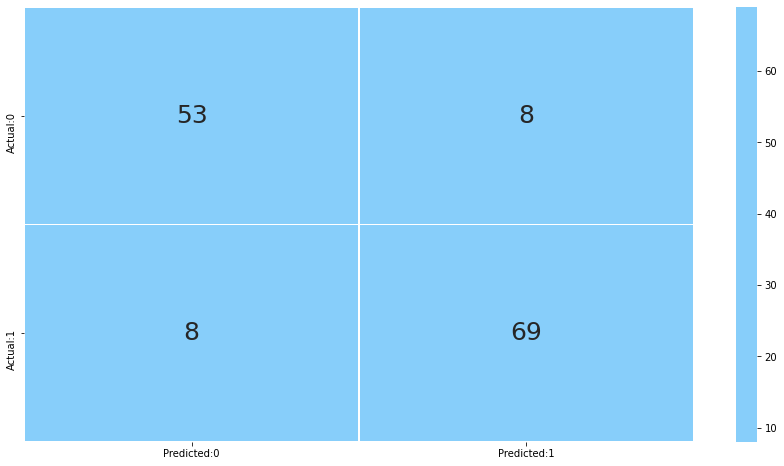

In [121]:
cm=confusion_matrix(y_test,y_pred_rf)
conf_mat=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_mat,annot=True,annot_kws={'size':25},linewidths=0.5,fmt='d',cmap=ListedColormap('lightskyblue'))
plt.show()

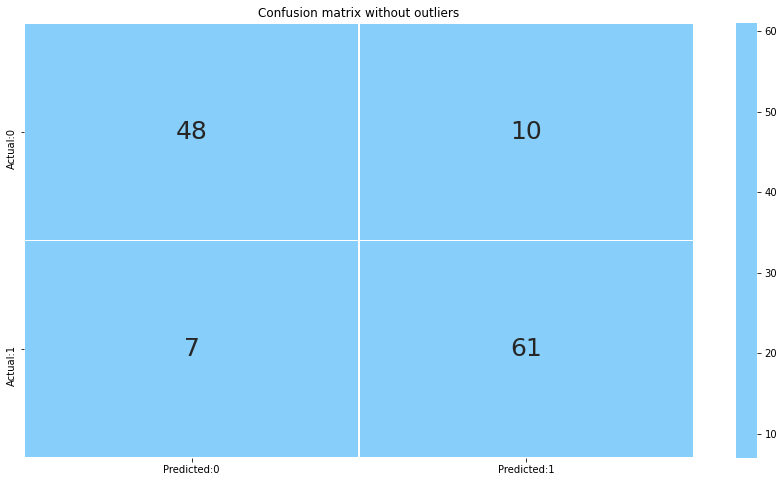

In [122]:
cm=confusion_matrix(yt_test,y_pred_rf1)
conf_mat=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_mat,annot=True,annot_kws={'size':25},linewidths=0.5,fmt='d',cmap=ListedColormap('lightskyblue'))
plt.title('Confusion matrix without outliers')
plt.show()

In [123]:
test_report=classification_report(y_test,y_pred_rf)
print(test_report)

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        61
         1.0       0.90      0.90      0.90        77

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138



In [124]:
test_report1=classification_report(yt_test,y_pred_rf1)
print('test report of RF Classifier without outliers')
print(test_report1)

test report of RF Classifier without outliers
              precision    recall  f1-score   support

         0.0       0.87      0.83      0.85        58
         1.0       0.86      0.90      0.88        68

    accuracy                           0.87       126
   macro avg       0.87      0.86      0.86       126
weighted avg       0.87      0.87      0.86       126



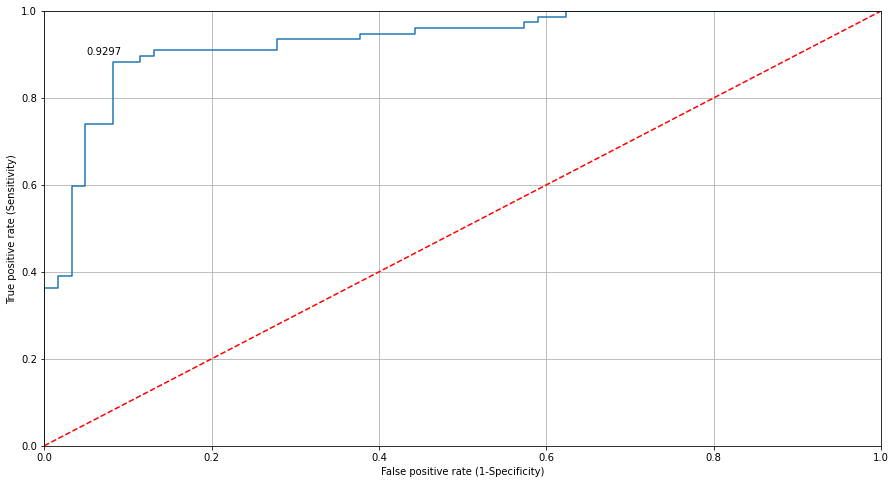

In [125]:
fpr,tpr,threshold=roc_curve(y_test,y_pred_prob_rf)
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.9,s=(round(roc_auc_score(y_test,y_pred_prob_rf),4)))
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()

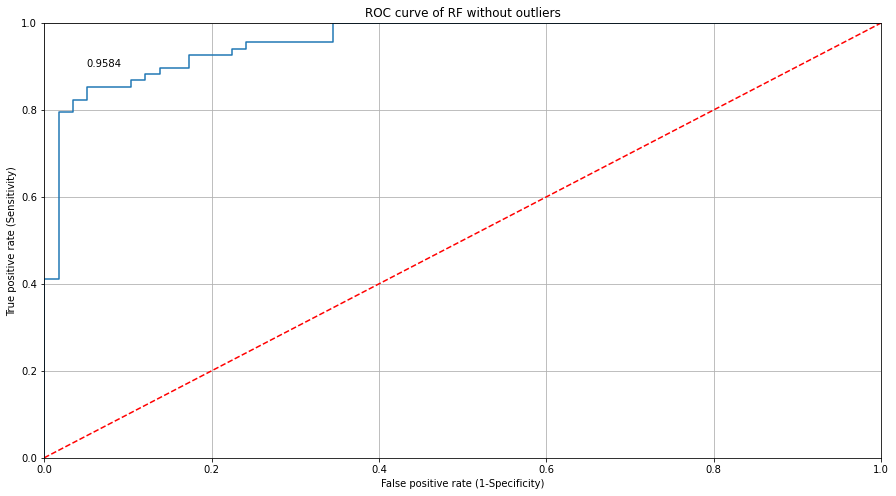

In [126]:
fpr,tpr,threshold=roc_curve(yt_test,y_pred_prob_rf1)
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.9,s=(round(roc_auc_score(yt_test,y_pred_prob_rf1),4)))
plt.title('ROC curve of RF without outliers')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()

In [128]:
cols = ['Model', 'AUC Score', 'Precision Score', 'Recall Score','Accuracy Score','f1-score']
result=pd.DataFrame(columns=cols)
RandomForest_cv=pd.Series({'Model':'Random Forest (5-fold CV)',
                          'AUC Score':roc_auc_score(y_test,y_pred_prob_rf),
                          'Precision Score':metrics.precision_score(y_test,y_pred_rf),
                          'Recall Score':metrics.recall_score(y_test,y_pred_rf),
                          'Accuracy Score':metrics.accuracy_score(y_test,y_pred_rf),
                          'f1-score':metrics.f1_score(y_test,y_pred_rf)})
result=result.append(RandomForest_cv,ignore_index=True)
result

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Random Forest (5-fold CV),0.929742,0.896104,0.896104,0.884058,0.896104


In [129]:
RandomForest1_cv=pd.Series({'Model':'Random Forest (5-cv/no outliers)',
                          'AUC Score':roc_auc_score(yt_test,y_pred_prob_rf1),
                          'Precision Score':metrics.precision_score(yt_test,y_pred_rf1),
                          'Recall Score':metrics.recall_score(yt_test,y_pred_rf1),
                          'Accuracy Score':metrics.accuracy_score(yt_test,y_pred_rf1),
                          'f1-score':metrics.f1_score(yt_test,y_pred_rf1)})
result=result.append(RandomForest1_cv,ignore_index=True)
result

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Random Forest (5-fold CV),0.929742,0.896104,0.896104,0.884058,0.896104
1,Random Forest (5-cv/no outliers),0.958418,0.859155,0.897059,0.865079,0.877698


In [133]:
tuned_param_abc=[{'n_estimators':[int(x) for x in np.linspace(start=100,stop=500,num=5)],
                 'learning_rate':[0.001,0.01,0.05,0.5,0.75,0.1]}]

In [134]:
abc=AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'),random_state=10)
grid=GridSearchCV(estimator=abc,param_grid=tuned_param_abc,cv=5,scoring='roc_auc',n_jobs=-1)
abc_grid=grid.fit(x_train1,y_train)
print('best parameter for Adaboost classifier: ',abc_grid.best_params_,'\n')

best parameter for Adaboost classifier:  {'learning_rate': 0.001, 'n_estimators': 100} 



In [135]:
abc1=AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'),random_state=10)
grid1=GridSearchCV(estimator=abc1,param_grid=tuned_param_abc,cv=5,scoring='roc_auc',n_jobs=-1)
abc_grid1=grid1.fit(xt_train1,yt_train)
print('best parameter for Adaboost classifier without outliers: ',abc_grid1.best_params_,'\n')

best parameter for Adaboost classifier without outliers:  {'learning_rate': 0.001, 'n_estimators': 100} 



In [136]:
abc_model=AdaBoostClassifier(n_estimators=100,learning_rate=0.001)
abc_model.fit(x_train1,y_train)

AdaBoostClassifier(learning_rate=0.001, n_estimators=100)

In [137]:
abc_model1=AdaBoostClassifier(n_estimators=100,learning_rate=0.001)
abc_model1.fit(xt_train1,yt_train)

AdaBoostClassifier(learning_rate=0.001, n_estimators=100)

In [138]:
abc_f1_cv=cross_val_score(abc_model,x_val1,y_val,scoring='f1',n_jobs=-1)
abc_acc_cv=cross_val_score(abc_model,x_val1,y_val,scoring='accuracy',n_jobs=-1)
print('Accuracy on the validation data: {:.2f}%'.format(abc_acc_cv.mean()*100))
print('F1-score on the validation data: {:.2f}%'.format(abc_f1_cv.mean()*100))

Accuracy on the validation data: 80.37%
F1-score on the validation data: 82.01%


In [139]:
print('ROC AUC score of Adaboost model: {:.4f}'.format(abc_grid.best_score_))

ROC AUC score of Adaboost model: 0.7882


We see a slight decline in performance in the AdaBoost model. The AUC decreased to 0.7882 and the overall accuracy and F1-score dropped to 80.4% and 82% respectively.

In [141]:
abc1_f1_cv=cross_val_score(abc_model1,xt_val1,yt_val,scoring='f1',n_jobs=-1)
abc1_acc_cv=cross_val_score(abc_model1,xt_val1,yt_val,scoring='accuracy',n_jobs=-1)
print('Accuracy on the validation data without outliers: {:.2f}%'.format(abc1_acc_cv.mean()*100))
print('F1-score on the validation data without outliers: {:.2f}%'.format(abc1_f1_cv.mean()*100))
print('ROC AUC score of Adaboost model without outliers: {:.4f}'.format(abc_grid1.best_score_))

Accuracy on the validation data without outliers: 68.00%
F1-score on the validation data without outliers: 66.66%
ROC AUC score of Adaboost model without outliers: 0.7860


We see a significant amount of decline in the performance of the AdaBoost model without outliers. The AUC decreased to 0.7860 and the overall accuracy and F1-score dropped to 68% and 66.6% respectively.

In [142]:
y_pred_abc=abc_model.predict(x_test1)
y_pred_abc1=abc_model1.predict(xt_test1)
y_pred_prob_abc=abc_model.predict_proba(x_test1)[:,1]
y_pred_prob_abc1=abc_model1.predict_proba(xt_test1)[:,1]

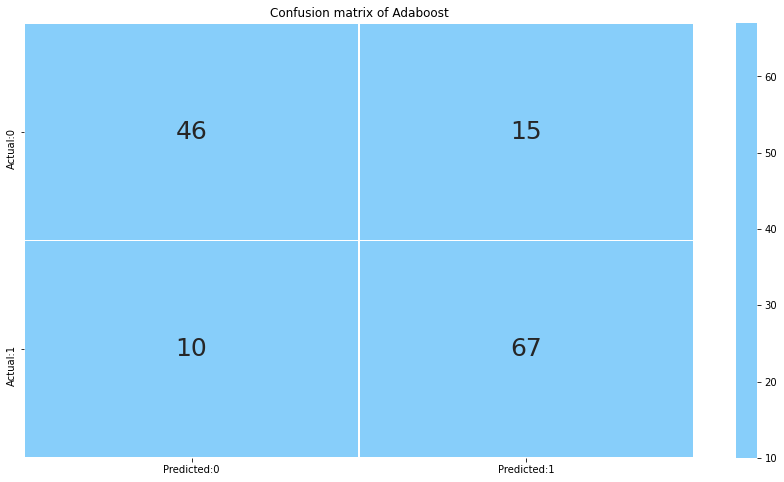

In [144]:
cm=confusion_matrix(y_test,y_pred_abc)
conf_mat=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_mat,annot=True,annot_kws={'size':25},linewidths=0.5,fmt='d',cmap=ListedColormap('lightskyblue'))
plt.title('Confusion matrix of Adaboost')
plt.show()

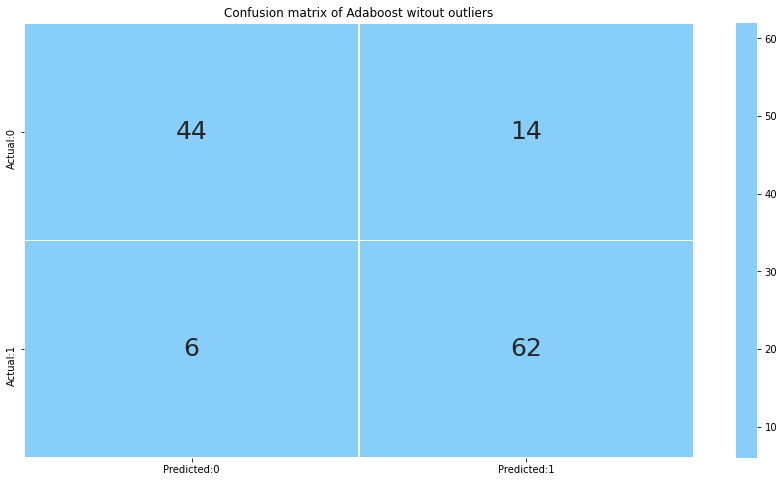

In [145]:
cm=confusion_matrix(yt_test,y_pred_abc1)
conf_mat=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_mat,annot=True,annot_kws={'size':25},linewidths=0.5,fmt='d',cmap=ListedColormap('lightskyblue'))
plt.title('Confusion matrix of Adaboost witout outliers')
plt.show()

In [146]:
test_report=classification_report(y_test,y_pred_abc)
print(test_report)

              precision    recall  f1-score   support

         0.0       0.82      0.75      0.79        61
         1.0       0.82      0.87      0.84        77

    accuracy                           0.82       138
   macro avg       0.82      0.81      0.81       138
weighted avg       0.82      0.82      0.82       138



In [147]:
test_report1=classification_report(yt_test,y_pred_abc1)
print('Classification report of Adaboost without outliers')
print(test_report1)

Classification report of Adaboost without outliers
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.81        58
         1.0       0.82      0.91      0.86        68

    accuracy                           0.84       126
   macro avg       0.85      0.84      0.84       126
weighted avg       0.85      0.84      0.84       126



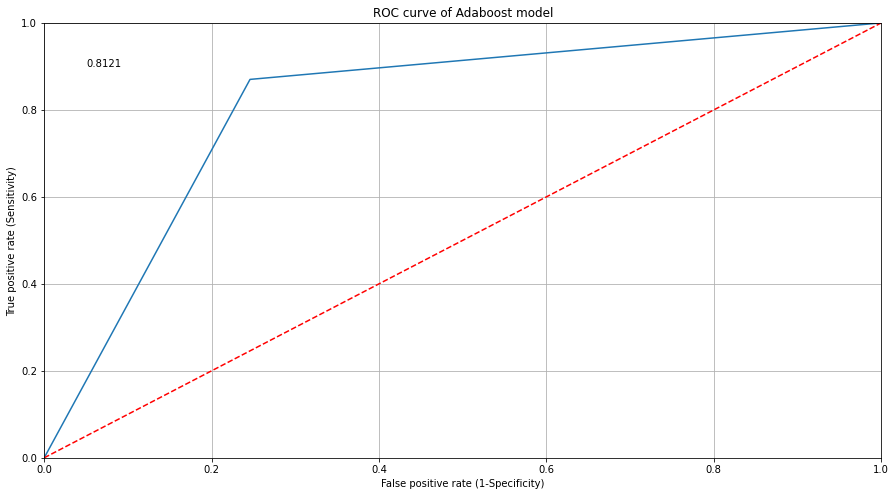

In [151]:
fpr,tpr,threshold=roc_curve(y_test,y_pred_prob_abc)
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.9,s=(round(roc_auc_score(y_test,y_pred_prob_abc),4)))
plt.title('ROC curve of Adaboost model')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()

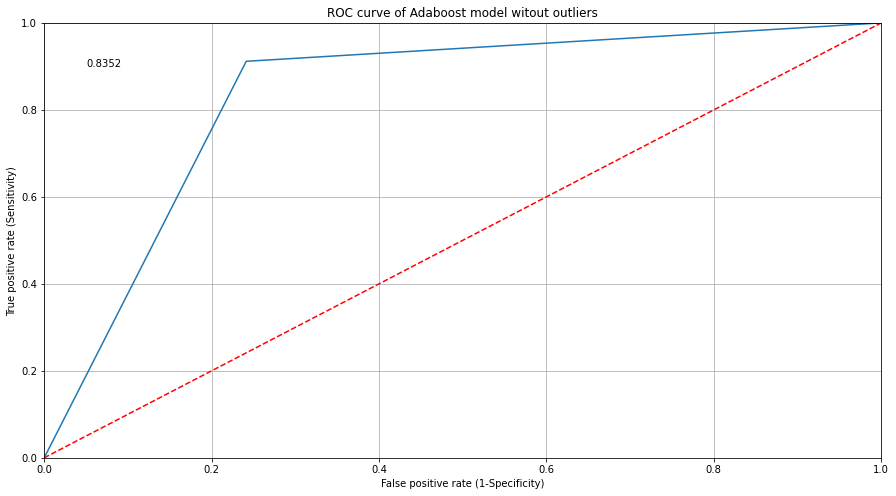

In [152]:
fpr,tpr,threshold=roc_curve(yt_test,y_pred_prob_abc1)
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.9,s=(round(roc_auc_score(yt_test,y_pred_prob_abc1),4)))
plt.title('ROC curve of Adaboost model witout outliers')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()

In [153]:
Adaboost_cv=pd.Series({'Model':'AdaBoost (5-fold CV)',
                          'AUC Score':roc_auc_score(y_test,y_pred_prob_abc),
                          'Precision Score':metrics.precision_score(y_test,y_pred_abc),
                          'Recall Score':metrics.recall_score(y_test,y_pred_abc),
                          'Accuracy Score':metrics.accuracy_score(y_test,y_pred_abc),
                          'f1-score':metrics.f1_score(y_test,y_pred_abc)})
result=result.append(Adaboost_cv,ignore_index=True)
result

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Random Forest (5-fold CV),0.929742,0.896104,0.896104,0.884058,0.896104
1,Random Forest (5-cv/no outliers),0.958418,0.859155,0.897059,0.865079,0.877698
2,AdaBoost (5-fold CV),0.812114,0.817073,0.870130,0.818841,0.842767


In [154]:
Adaboost1_cv=pd.Series({'Model':'AdaBoost (5-CV/no outliers)',
                          'AUC Score':roc_auc_score(yt_test,y_pred_prob_abc1),
                          'Precision Score':metrics.precision_score(yt_test,y_pred_abc1),
                          'Recall Score':metrics.recall_score(yt_test,y_pred_abc1),
                          'Accuracy Score':metrics.accuracy_score(yt_test,y_pred_abc1),
                          'f1-score':metrics.f1_score(yt_test,y_pred_abc1)})
result=result.append(Adaboost1_cv,ignore_index=True)
result

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Random Forest (5-fold CV),0.929742,0.896104,0.896104,0.884058,0.896104
1,Random Forest (5-cv/no outliers),0.958418,0.859155,0.897059,0.865079,0.877698
2,AdaBoost (5-fold CV),0.812114,0.817073,0.870130,0.818841,0.842767
3,AdaBoost (5-CV/no outliers),0.835193,0.815789,0.911765,0.841270,0.861111


In [155]:
tuned_param_xgbc=[{'n_estimators':[int(x) for x in np.linspace(start=100,stop=500,num=5)],
                  'max_depth':[5,10,15,20],
                  'learning_rate':[0.005,0.01,0.05,0.1]}]

In [156]:
xgbc=XGBClassifier(random_state=10)
grid=GridSearchCV(estimator=xgbc,param_grid=tuned_param_xgbc,cv=5,scoring='roc_auc',n_jobs=-1)
xgbc_grid=grid.fit(x_train1,y_train)
print('best parameter for XGB classifier: ',xgbc_grid.best_params_,'\n')

[11:55:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best parameter for XGB classifier:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100} 



In [157]:
xgbc1=XGBClassifier(random_state=10)
grid1=GridSearchCV(estimator=xgbc1,param_grid=tuned_param_xgbc,cv=5,scoring='roc_auc',n_jobs=-1)
xgbc_grid1=grid1.fit(xt_train1,yt_train)
print('best parameter for XGB classifier without outliers: ',xgbc_grid1.best_params_,'\n')

[12:12:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best parameter for XGB classifier without outliers:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400} 



In [158]:
xgb_model=XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=5,random_state=10)
xgb_model.fit(x_train1,y_train)

[12:20:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [159]:
xgb_model1=XGBClassifier(n_estimators=400,learning_rate=0.01,max_depth=5,random_state=10)
xgb_model1.fit(xt_train1,yt_train)

[12:21:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [160]:
xgb_f1_cv=cross_val_score(xgb_model,x_val1,y_val,scoring='f1',n_jobs=-1)
xgb_acc_cv=cross_val_score(xgb_model,x_val1,y_val,scoring='accuracy',n_jobs=-1)
print('accuracy on the validation data: {:.2f}%'.format(xgb_acc_cv.mean()*100))
print('F1-Score on the validation data: {:.2f}%'.format(xgb_f1_cv.mean()*100))

accuracy on the validation data: 86.11%
F1-Score on the validation data: 87.85%


In [161]:
print('ROC AUC score of XGBoost model: {:.4f}'.format(xgbc_grid.best_score_))

ROC AUC score of XGBoost model: 0.9260


The XGBoost model improves on the performance of the AdaBoost model across all 3 metrics, with an Area Under the Curve of 0.9260. On the validation set, the model produces an average accuracy of 86.11% and an F1-score of about 87.85%. Kindly similar to our Random forest model.

In [162]:
xgb1_f1_cv=cross_val_score(xgb_model1,xt_val1,yt_val,scoring='f1',n_jobs=-1)
xgb1_acc_cv=cross_val_score(xgb_model1,xt_val1,yt_val,scoring='accuracy',n_jobs=-1)
print('accuracy on the validation data without outliers: {:.2f}%'.format(xgb1_acc_cv.mean()*100))
print('F1-Score on the validation data without outliers: {:.2f}%'.format(xgb1_f1_cv.mean()*100))
print('ROC AUC score of XGBoost model without outliers: {:.4f}'.format(xgbc_grid1.best_score_))

accuracy on the validation data without outliers: 72.80%
F1-Score on the validation data without outliers: 76.18%
ROC AUC score of XGBoost model without outliers: 0.9214


The XGBoost model witout outliers is having an Area Under the Curve of 0.9214. On the validation set, the model produces an average accuracy of around 73% and an F1-score of about 76.18%.

In [163]:
y_pred_xgb=xgb_model.predict(x_test1)
y_pred_xgb1=xgb_model1.predict(xt_test1)
y_pred_prob_xgb=xgb_model.predict_proba(x_test1)[:,1]
y_pred_prob_xgb1=xgb_model1.predict_proba(xt_test1)[:,1]

In [164]:
y_pred_prob_xgb.shape

(138,)

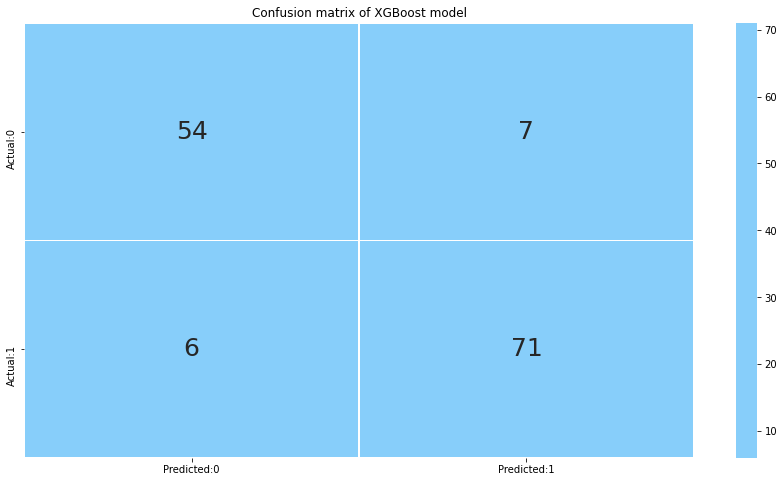

In [165]:
cm=confusion_matrix(y_test,y_pred_xgb)
conf_mat=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_mat,annot=True,annot_kws={'size':25},linewidths=0.5,fmt='d',cmap=ListedColormap('lightskyblue'))
plt.title('Confusion matrix of XGBoost model')
plt.show()

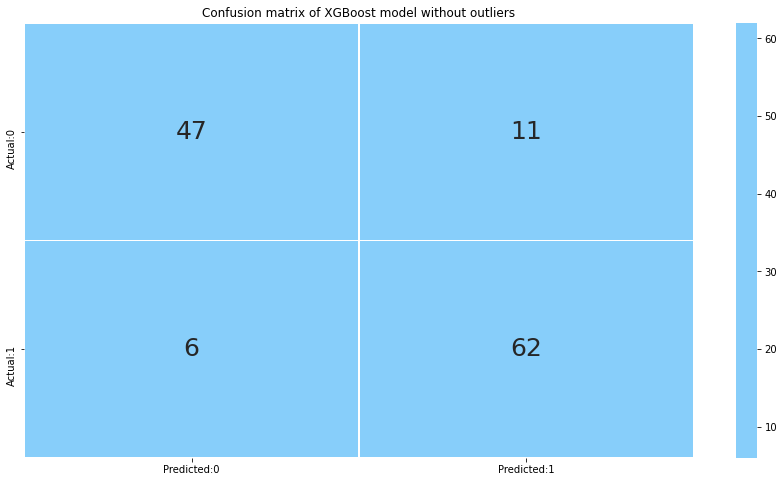

In [166]:
cm=confusion_matrix(yt_test,y_pred_xgb1)
conf_mat=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_mat,annot=True,annot_kws={'size':25},linewidths=0.5,fmt='d',cmap=ListedColormap('lightskyblue'))
plt.title('Confusion matrix of XGBoost model without outliers')
plt.show()

In [167]:
test_report=classification_report(y_test,y_pred_xgb)
print(test_report)

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89        61
         1.0       0.91      0.92      0.92        77

    accuracy                           0.91       138
   macro avg       0.91      0.90      0.90       138
weighted avg       0.91      0.91      0.91       138



In [168]:
test_report1=classification_report(yt_test,y_pred_xgb1)
print(test_report1)

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85        58
         1.0       0.85      0.91      0.88        68

    accuracy                           0.87       126
   macro avg       0.87      0.86      0.86       126
weighted avg       0.87      0.87      0.86       126



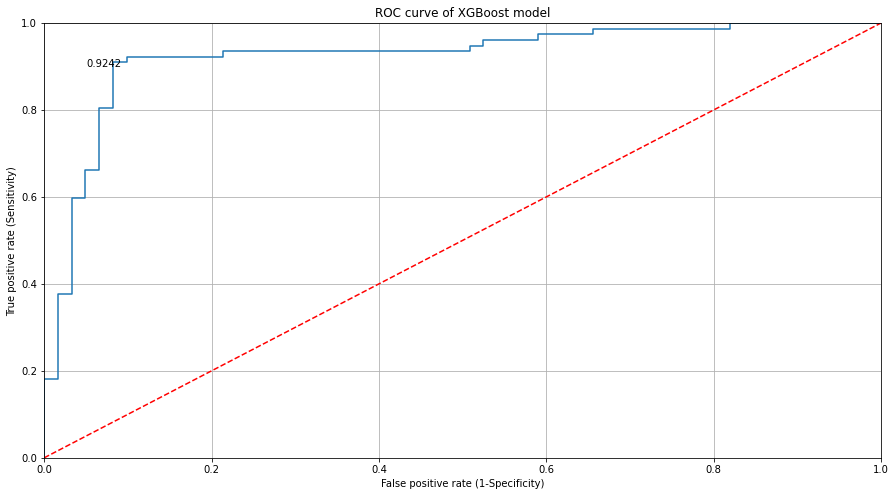

In [169]:
fpr,tpr,threshold=roc_curve(y_test,y_pred_prob_xgb)
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.9,s=(round(roc_auc_score(y_test,y_pred_prob_xgb),4)))
plt.title('ROC curve of XGBoost model')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()

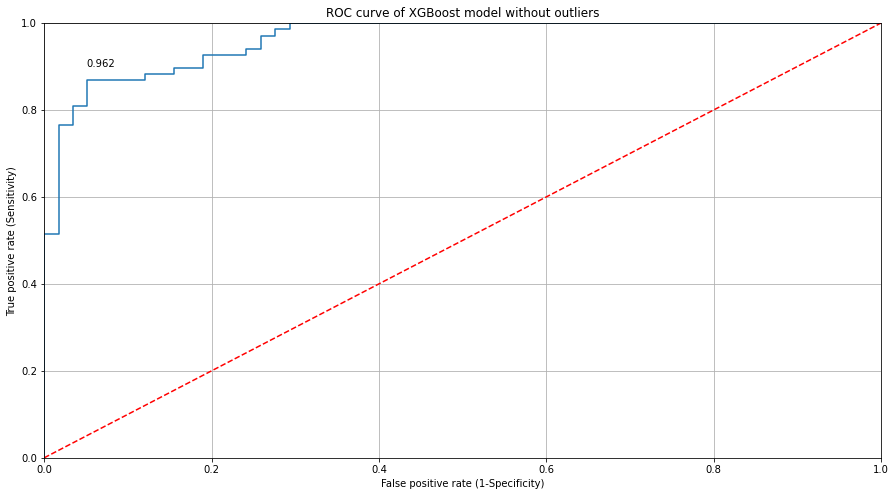

In [170]:
fpr,tpr,threshold=roc_curve(yt_test,y_pred_prob_xgb1)
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.9,s=(round(roc_auc_score(yt_test,y_pred_prob_xgb1),4)))
plt.title('ROC curve of XGBoost model without outliers')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()

In [171]:
XGboost_cv=pd.Series({'Model':'XGBoost (5-fold CV)',
                          'AUC Score':roc_auc_score(y_test,y_pred_prob_xgb),
                          'Precision Score':metrics.precision_score(y_test,y_pred_xgb),
                          'Recall Score':metrics.recall_score(y_test,y_pred_xgb),
                          'Accuracy Score':metrics.accuracy_score(y_test,y_pred_xgb),
                          'f1-score':metrics.f1_score(y_test,y_pred_xgb)})
result=result.append(XGboost_cv,ignore_index=True)
result

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Random Forest (5-fold CV),0.929742,0.896104,0.896104,0.884058,0.896104
1,Random Forest (5-cv/no outliers),0.958418,0.859155,0.897059,0.865079,0.877698
2,AdaBoost (5-fold CV),0.812114,0.817073,0.870130,0.818841,0.842767
3,AdaBoost (5-CV/no outliers),0.835193,0.815789,0.911765,0.841270,0.861111
4,XGBoost (5-fold CV),0.924207,0.910256,0.922078,0.905797,0.916129


In [172]:
XGboost1_cv=pd.Series({'Model':'XGBoost (5-CV/No outliers)',
                          'AUC Score':roc_auc_score(yt_test,y_pred_prob_xgb1),
                          'Precision Score':metrics.precision_score(yt_test,y_pred_xgb1),
                          'Recall Score':metrics.recall_score(yt_test,y_pred_xgb1),
                          'Accuracy Score':metrics.accuracy_score(yt_test,y_pred_xgb1),
                          'f1-score':metrics.f1_score(yt_test,y_pred_xgb1)})
result=result.append(XGboost1_cv,ignore_index=True)
result

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Random Forest (5-fold CV),0.929742,0.896104,0.896104,0.884058,0.896104
1,Random Forest (5-cv/no outliers),0.958418,0.859155,0.897059,0.865079,0.877698
2,AdaBoost (5-fold CV),0.812114,0.817073,0.870130,0.818841,0.842767
3,AdaBoost (5-CV/no outliers),0.835193,0.815789,0.911765,0.841270,0.861111
4,XGBoost (5-fold CV),0.924207,0.910256,0.922078,0.905797,0.916129
5,XGBoost (5-CV/No outliers),0.961968,0.849315,0.911765,0.865079,0.879433


In [173]:
tuned_param_lgbm=[{'boosting_type':['gbdt','dart'],
                  'num_leaves':[int(x) for x in np.linspace(start=20,stop=50,num=7)],
                  'max_depth':[3,7,14,21],
                  'learning_rate':[0.01,0.05,0.1,0.5,1],
                  'n_estimators':[int(x) for x in np.linspace(start=100,stop=500,num=5)],
                  'min_child_samples':[5,7,9],
                  'subsample': [0.5, 0.8, 0.95]}]

In [179]:
lgb=LGBMClassifier(class_weight='balanced',random_state=10)
grid=GridSearchCV(estimator=lgb,param_grid=tuned_param_lgbm,cv=5,scoring='roc_auc',n_jobs=-1)
lgb_grid=grid.fit(x_train1,y_train)
print('best parameter for XGB classifier: ',lgb_grid.best_params_,'\n')

best parameter for XGB classifier:  {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 9, 'n_estimators': 100, 'num_leaves': 20, 'subsample': 0.5} 



In [180]:
lgb1=LGBMClassifier(class_weight='balanced',random_state=10)
grid1=GridSearchCV(estimator=lgb1,param_grid=tuned_param_lgbm,cv=5,scoring='roc_auc',n_jobs=-1)
lgb_grid1=grid1.fit(xt_train1,yt_train)
print('best parameter for LGB classifier without outliers: ',lgb_grid1.best_params_,'\n')

best parameter for LGB classifier without outliers:  {'boosting_type': 'dart', 'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 9, 'n_estimators': 400, 'num_leaves': 20, 'subsample': 0.5} 



In [181]:
lgb_model=LGBMClassifier(boosting_type='gbdt',num_leaves=20,class_weight='balanced',learning_rate=0.05,max_depth=3,min_child_samples=9,n_estimators=100,subsample=0.5,random_state=10)
lgb_model.fit(x_train1,y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=3,
               min_child_samples=9, num_leaves=20, random_state=10,
               subsample=0.5)

In [182]:
lgb_model1=LGBMClassifier(boosting_type='dart',num_leaves=20,class_weight='balanced',learning_rate=0.05,max_depth=3,min_child_samples=9,n_estimators=400,subsample=0.5,random_state=10)
lgb_model1.fit(xt_train1,yt_train)

LGBMClassifier(boosting_type='dart', class_weight='balanced',
               learning_rate=0.05, max_depth=3, min_child_samples=9,
               n_estimators=400, num_leaves=20, random_state=10, subsample=0.5)

In [183]:
lgb_f1_cv=cross_val_score(lgb_model,x_val1,y_val,scoring='f1',n_jobs=-1)
lgb_acc_cv=cross_val_score(lgb_model,x_val1,y_val,scoring='accuracy',n_jobs=-1)
print('accuracy on the validation data: {:.2f}%'.format(lgb_acc_cv.mean()*100))
print('F1-Score on the validation data: {:.2f}%'.format(lgb_f1_cv.mean()*100))

accuracy on the validation data: 88.33%
F1-Score on the validation data: 89.59%


In [184]:
print('ROC AUC score of LGBM classifier model: {:.4f}'.format(lgb_grid.best_score_))

ROC AUC score of LGBM classifier model: 0.9322


The Light Gradient Boosting model produces the highest Area Under the Curve out of the classifiers at 0.9322. In addition, the model has the accuracy almost 88.33% and the F1-score to 89.6% on the validation set.

In [185]:
lgb1_f1_cv=cross_val_score(lgb_model1,xt_val1,yt_val,scoring='f1',n_jobs=-1)
lgb1_acc_cv=cross_val_score(lgb_model1,xt_val1,yt_val,scoring='accuracy',n_jobs=-1)
print('accuracy on the validation data without outliers: {:.2f}%'.format(lgb1_acc_cv.mean()*100))
print('F1-Score on the validation data without outliers: {:.2f}%'.format(lgb1_f1_cv.mean()*100))
print('ROC AUC score of LGBM classifier model without outliers: {:.4f}'.format(lgb_grid1.best_score_))

accuracy on the validation data without outliers: 74.40%
F1-Score on the validation data without outliers: 76.32%
ROC AUC score of LGBM classifier model without outliers: 0.9321


The Light Gradient Boosting model produces the Area Under the Curve out of 0.9321. In addition, the model has the accuracy almost 74.4% and the F1-score to 76.32% on the validation set.

In [186]:
y_pred_lgb=lgb_model.predict(x_test1)
y_pred_lgb1=lgb_model1.predict(xt_test1)
y_pred_prob_lgb=lgb_model.predict_proba(x_test1)[:,1]
y_pred_prob_lgb1=lgb_model1.predict_proba(xt_test1)[:,1]

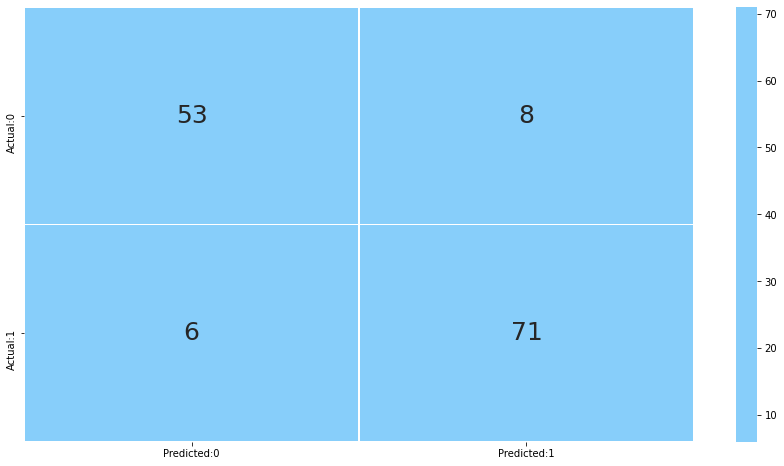

In [187]:
cm=confusion_matrix(y_test,y_pred_lgb)
conf_mat=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_mat,annot=True,annot_kws={'size':25},linewidths=0.5,fmt='d',cmap=ListedColormap('lightskyblue'))
plt.show()

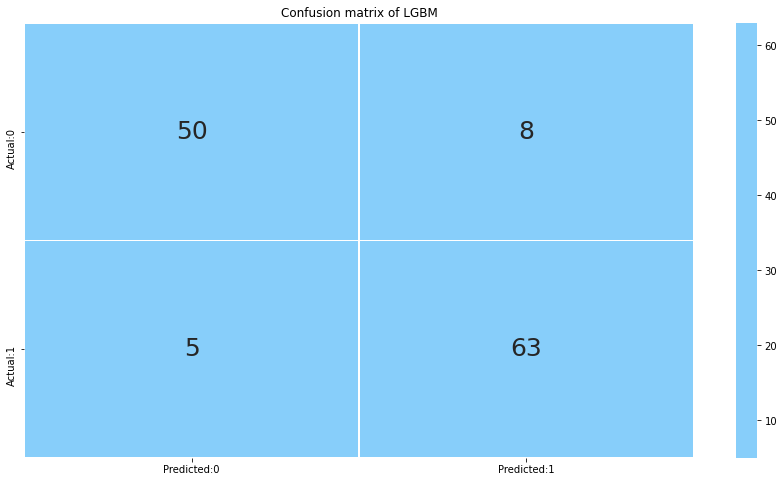

In [188]:
cm=confusion_matrix(yt_test,y_pred_lgb1)
conf_mat=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_mat,annot=True,annot_kws={'size':25},linewidths=0.5,fmt='d',cmap=ListedColormap('lightskyblue'))
plt.title('Confusion matrix of LGBM')
plt.show()

In [189]:
test_report=classification_report(y_test,y_pred_lgb)
print(test_report)

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88        61
         1.0       0.90      0.92      0.91        77

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138



In [190]:
test_report1=classification_report(yt_test,y_pred_lgb1)
print('classification report of LGBM model')
print(test_report1)

classification report of LGBM model
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88        58
         1.0       0.89      0.93      0.91        68

    accuracy                           0.90       126
   macro avg       0.90      0.89      0.90       126
weighted avg       0.90      0.90      0.90       126



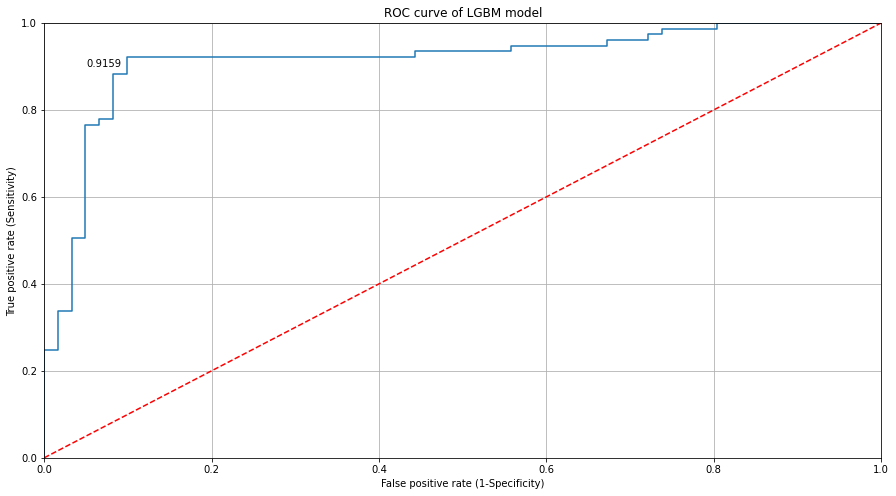

In [191]:
fpr,tpr,threshold=roc_curve(y_test,y_pred_prob_lgb)
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.9,s=(round(roc_auc_score(y_test,y_pred_prob_lgb),4)))
plt.title('ROC curve of LGBM model')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()

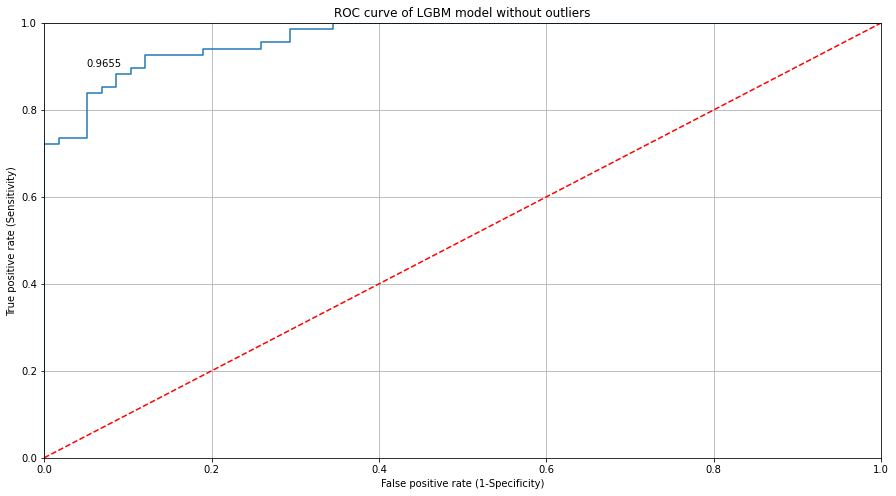

In [193]:
fpr,tpr,threshold=roc_curve(yt_test,y_pred_prob_lgb1)
plt.plot(fpr,tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--')
plt.text(x=0.05,y=0.9,s=(round(roc_auc_score(yt_test,y_pred_prob_lgb1),4)))
plt.title('ROC curve of LGBM model without outliers')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.show()

In [194]:
lgbm_cv=pd.Series({'Model':'LGBM (5-fold CV)',
                          'AUC Score':roc_auc_score(y_test,y_pred_prob_lgb),
                          'Precision Score':metrics.precision_score(y_test,y_pred_lgb),
                          'Recall Score':metrics.recall_score(y_test,y_pred_lgb),
                          'Accuracy Score':metrics.accuracy_score(y_test,y_pred_lgb),
                          'f1-score':metrics.f1_score(y_test,y_pred_lgb)})
result=result.append(lgbm_cv,ignore_index=True)
result

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Random Forest (5-fold CV),0.929742,0.896104,0.896104,0.884058,0.896104
1,Random Forest (5-cv/no outliers),0.958418,0.859155,0.897059,0.865079,0.877698
2,AdaBoost (5-fold CV),0.812114,0.817073,0.870130,0.818841,0.842767
3,AdaBoost (5-CV/no outliers),0.835193,0.815789,0.911765,0.841270,0.861111
4,XGBoost (5-fold CV),0.924207,0.910256,0.922078,0.905797,0.916129
5,XGBoost (5-CV/No outliers),0.961968,0.849315,0.911765,0.865079,0.879433
6,LGBM (5-fold CV),0.915904,0.898734,0.922078,0.898551,0.910256


In [195]:
lgbm1_cv=pd.Series({'Model':'LGBM (5-CV/No outliers)',
                          'AUC Score':roc_auc_score(yt_test,y_pred_prob_lgb1),
                          'Precision Score':metrics.precision_score(yt_test,y_pred_lgb1),
                          'Recall Score':metrics.recall_score(yt_test,y_pred_lgb1),
                          'Accuracy Score':metrics.accuracy_score(yt_test,y_pred_lgb1),
                          'f1-score':metrics.f1_score(yt_test,y_pred_lgb1)})
result=result.append(lgbm1_cv,ignore_index=True)
result

,Model,AUC Score,Precision Score,Recall Score,Accuracy Score,f1-score
0,Random Forest (5-fold CV),0.929742,0.896104,0.896104,0.884058,0.896104
1,Random Forest (5-cv/no outliers),0.958418,0.859155,0.897059,0.865079,0.877698
2,AdaBoost (5-fold CV),0.812114,0.817073,0.870130,0.818841,0.842767
3,AdaBoost (5-CV/no outliers),0.835193,0.815789,0.911765,0.841270,0.861111
4,XGBoost (5-fold CV),0.924207,0.910256,0.922078,0.905797,0.916129
5,XGBoost (5-CV/No outliers),0.961968,0.849315,0.911765,0.865079,0.879433
6,LGBM (5-fold CV),0.915904,0.898734,0.922078,0.898551,0.910256
7,LGBM (5-CV/No outliers),0.965517,0.887324,0.926471,0.896825,0.906475
